# Chia Pudding Oscillation

Replicate pyRheo oscillatory fits on chia pudding and compare generalized vs fractional models.

**Data:** examples/data/oscillation/foods/oscillation_chia_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell
from rheojax.models import HerschelBulkley

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


## Load frequency sweep data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'oscillation' / 'foods'
df = pd.read_csv(DATA_DIR / 'oscillation_chia_data.csv')
df.columns = df.columns.str.strip()

omega = df['Angular Frequency'].to_numpy()  # rad/s from source
freq_hz = omega / (2 * np.pi)
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j * Gpp

data = RheoData(x=omega, y=G_star, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'test_mode': 'oscillation'})
print(df.head())


   Angular Frequency  Storage Modulus  Loss Modulus
0              100.0           178.11       228.460
1               67.2           162.94       150.620
2               45.2           141.52       111.450
3               30.4           126.71        89.679
4               20.4           114.69        71.740


## Fit generalized vs fractional models

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:, 0] + 1j * gm_pred_components[:, 1]
gm_r2 = r2_complex(G_star, gm_pred)

fm_pred = np.full_like(G_star, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega, test_mode='oscillation')
    fm_r2 = r2_complex(G_star, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.233621s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=210.1308 | elapsed=3.234s | final_gradient_norm=1.7771e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.809026s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=210.1308 | elapsed=0.809s | final_gradient_norm=1.7771e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.498568s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=23 | final_cost=448.7314 | elapsed=1.499s | final_gradient_norm=1.2996e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.795029s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=1.8860 | elapsed=1.795s | final_gradient_norm=58.8164


{'gm_r2': 0.996112253387286, 'fm_r2': 0.48832300683730034}


## Visualize fits

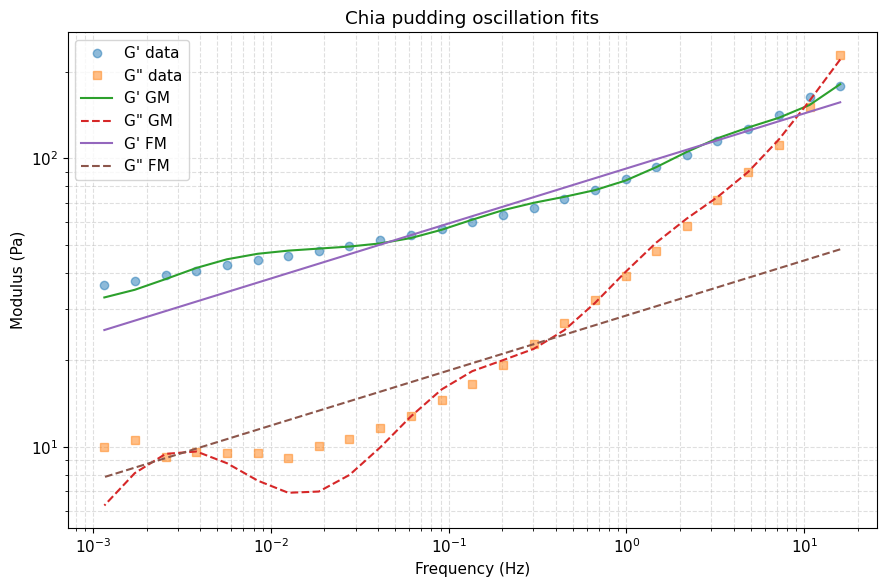

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(gm_pred), '-', label="G' GM")
ax.loglog(freq_hz, np.imag(gm_pred), '--', label='G" GM')
if np.isfinite(fm_r2):
    ax.loglog(freq_hz, np.real(fm_pred), '-', label="G' FM")
    ax.loglog(freq_hz, np.imag(fm_pred), '--', label='G" FM')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.set_title('Chia pudding oscillation fits')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.693118s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=210.1308 | elapsed=0.693s | final_gradient_norm=1.7771e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.757204s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=210.1308 | elapsed=0.757s | final_gradient_norm=1.7771e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.507893s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=23 | final_cost=448.7314 | elapsed=0.508s | final_gradient_norm=1.2996e+06


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.521573s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=1.8860 | elapsed=0.522s | final_gradient_norm=58.8164


Model ranking (R²): [('fm', 0.488)]


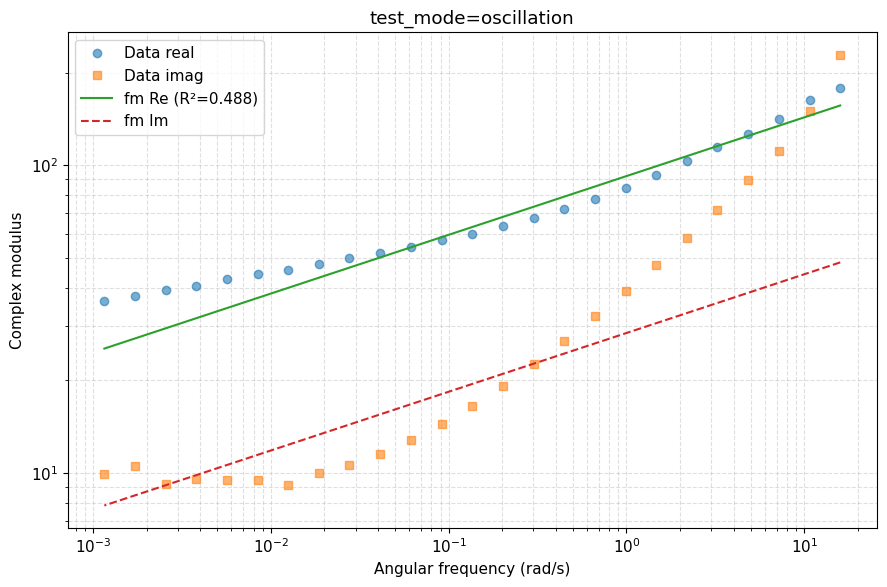

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:05<6:08:11,  5.52s/it]

warmup:   0%|          | 2/4000 [00:12<6:57:25,  6.26s/it]

warmup:   0%|          | 20/4000 [00:12<26:11,  2.53it/s] 

warmup:   1%|          | 27/4000 [00:12<18:18,  3.62it/s]

warmup:   1%|          | 32/4000 [00:12<14:18,  4.62it/s]

warmup:   1%|          | 36/4000 [00:13<11:41,  5.65it/s]

warmup:   1%|          | 40/4000 [00:13<09:25,  7.01it/s]

warmup:   1%|          | 44/4000 [00:13<07:41,  8.58it/s]

warmup:   1%|          | 47/4000 [00:13<06:45,  9.76it/s]

warmup:   1%|▏         | 50/4000 [00:13<05:40, 11.59it/s]

warmup:   1%|▏         | 54/4000 [00:13<04:28, 14.71it/s]

warmup:   1%|▏         | 57/4000 [00:13<04:00, 16.42it/s]

warmup:   2%|▏         | 60/4000 [00:14<03:42, 17.68it/s]

warmup:   2%|▏         | 63/4000 [00:14<03:21, 19.51it/s]

warmup:   2%|▏         | 67/4000 [00:14<03:00, 21.84it/s]

warmup:   2%|▏         | 70/4000 [00:14<03:15, 20.09it/s]

warmup:   2%|▏         | 73/4000 [00:14<03:20, 19.63it/s]

warmup:   2%|▏         | 76/4000 [00:14<03:14, 20.20it/s]

warmup:   2%|▏         | 79/4000 [00:15<03:22, 19.34it/s]

warmup:   2%|▏         | 82/4000 [00:15<03:10, 20.52it/s]

warmup:   2%|▏         | 85/4000 [00:15<03:01, 21.63it/s]

warmup:   2%|▏         | 89/4000 [00:15<02:50, 22.91it/s]

warmup:   2%|▏         | 92/4000 [00:15<02:40, 24.42it/s]

warmup:   2%|▏         | 95/4000 [00:15<02:39, 24.51it/s]

warmup:   2%|▏         | 98/4000 [00:15<02:37, 24.72it/s]

warmup:   3%|▎         | 101/4000 [00:15<02:36, 24.98it/s]

warmup:   3%|▎         | 104/4000 [00:16<02:54, 22.28it/s]

warmup:   3%|▎         | 107/4000 [00:16<03:08, 20.68it/s]

warmup:   3%|▎         | 110/4000 [00:16<03:02, 21.27it/s]

warmup:   3%|▎         | 113/4000 [00:16<03:00, 21.58it/s]

warmup:   3%|▎         | 116/4000 [00:16<02:57, 21.83it/s]

warmup:   3%|▎         | 119/4000 [00:16<03:02, 21.26it/s]

warmup:   3%|▎         | 122/4000 [00:16<03:07, 20.71it/s]

warmup:   3%|▎         | 125/4000 [00:17<03:02, 21.21it/s]

warmup:   3%|▎         | 128/4000 [00:17<03:02, 21.26it/s]

warmup:   3%|▎         | 131/4000 [00:17<03:15, 19.83it/s]

warmup:   3%|▎         | 134/4000 [00:17<03:08, 20.56it/s]

warmup:   3%|▎         | 137/4000 [00:17<02:59, 21.51it/s]

warmup:   4%|▎         | 140/4000 [00:17<02:56, 21.92it/s]

warmup:   4%|▎         | 143/4000 [00:17<02:53, 22.18it/s]

warmup:   4%|▎         | 146/4000 [00:18<02:59, 21.44it/s]

warmup:   4%|▎         | 149/4000 [00:18<03:00, 21.32it/s]

warmup:   4%|▍         | 152/4000 [00:18<02:50, 22.60it/s]

warmup:   4%|▍         | 155/4000 [00:18<03:08, 20.42it/s]

warmup:   4%|▍         | 158/4000 [00:18<03:08, 20.41it/s]

warmup:   4%|▍         | 161/4000 [00:18<02:58, 21.48it/s]

warmup:   4%|▍         | 164/4000 [00:18<03:15, 19.64it/s]

warmup:   4%|▍         | 167/4000 [00:19<04:18, 14.84it/s]

warmup:   4%|▍         | 169/4000 [00:19<04:16, 14.95it/s]

warmup:   4%|▍         | 171/4000 [00:19<04:37, 13.80it/s]

warmup:   4%|▍         | 173/4000 [00:19<04:20, 14.68it/s]

warmup:   4%|▍         | 175/4000 [00:19<04:19, 14.75it/s]

warmup:   4%|▍         | 177/4000 [00:19<04:07, 15.46it/s]

warmup:   4%|▍         | 179/4000 [00:20<04:00, 15.91it/s]

warmup:   5%|▍         | 182/4000 [00:20<03:38, 17.48it/s]

warmup:   5%|▍         | 184/4000 [00:20<04:51, 13.09it/s]

warmup:   5%|▍         | 187/4000 [00:20<04:01, 15.82it/s]

warmup:   5%|▍         | 189/4000 [00:20<04:14, 14.95it/s]

warmup:   5%|▍         | 191/4000 [00:20<04:32, 13.95it/s]

warmup:   5%|▍         | 193/4000 [00:20<04:12, 15.09it/s]

warmup:   5%|▍         | 195/4000 [00:21<04:32, 13.98it/s]

warmup:   5%|▍         | 197/4000 [00:21<04:21, 14.52it/s]

warmup:   5%|▌         | 200/4000 [00:21<03:52, 16.33it/s]

warmup:   5%|▌         | 203/4000 [00:21<03:36, 17.56it/s]

warmup:   5%|▌         | 206/4000 [00:21<03:27, 18.29it/s]

warmup:   5%|▌         | 209/4000 [00:21<03:13, 19.60it/s]

warmup:   5%|▌         | 211/4000 [00:21<03:20, 18.93it/s]

warmup:   5%|▌         | 214/4000 [00:22<03:10, 19.84it/s]

warmup:   5%|▌         | 216/4000 [00:22<03:12, 19.61it/s]

warmup:   6%|▌         | 220/4000 [00:22<02:46, 22.67it/s]

warmup:   6%|▌         | 223/4000 [00:22<02:54, 21.59it/s]

warmup:   6%|▌         | 226/4000 [00:22<02:48, 22.41it/s]

warmup:   6%|▌         | 229/4000 [00:22<02:39, 23.59it/s]

warmup:   6%|▌         | 232/4000 [00:22<02:40, 23.46it/s]

warmup:   6%|▌         | 235/4000 [00:23<02:59, 21.03it/s]

warmup:   6%|▌         | 238/4000 [00:23<02:46, 22.54it/s]

warmup:   6%|▌         | 241/4000 [00:23<02:40, 23.41it/s]

warmup:   6%|▌         | 244/4000 [00:23<02:32, 24.61it/s]

warmup:   6%|▌         | 247/4000 [00:23<02:41, 23.29it/s]

warmup:   6%|▋         | 250/4000 [00:23<02:35, 24.07it/s]

warmup:   6%|▋         | 254/4000 [00:23<02:28, 25.20it/s]

warmup:   6%|▋         | 257/4000 [00:24<03:38, 17.13it/s]

warmup:   6%|▋         | 260/4000 [00:24<04:13, 14.77it/s]

warmup:   7%|▋         | 262/4000 [00:24<04:27, 13.95it/s]

warmup:   7%|▋         | 264/4000 [00:24<04:24, 14.14it/s]

warmup:   7%|▋         | 267/4000 [00:24<04:01, 15.46it/s]

warmup:   7%|▋         | 269/4000 [00:24<03:51, 16.09it/s]

warmup:   7%|▋         | 272/4000 [00:25<03:20, 18.57it/s]

warmup:   7%|▋         | 274/4000 [00:25<03:28, 17.84it/s]

warmup:   7%|▋         | 276/4000 [00:25<03:54, 15.86it/s]

warmup:   7%|▋         | 278/4000 [00:25<04:08, 14.97it/s]

warmup:   7%|▋         | 280/4000 [00:25<04:10, 14.87it/s]

warmup:   7%|▋         | 282/4000 [00:25<04:21, 14.23it/s]

warmup:   7%|▋         | 284/4000 [00:26<05:54, 10.50it/s]

warmup:   7%|▋         | 286/4000 [00:26<05:33, 11.12it/s]

warmup:   7%|▋         | 288/4000 [00:26<05:04, 12.18it/s]

warmup:   7%|▋         | 290/4000 [00:26<05:15, 11.75it/s]

warmup:   7%|▋         | 292/4000 [00:26<05:20, 11.56it/s]

warmup:   7%|▋         | 294/4000 [00:26<04:56, 12.50it/s]

warmup:   7%|▋         | 297/4000 [00:27<04:04, 15.13it/s]

warmup:   8%|▊         | 300/4000 [00:27<03:28, 17.79it/s]

warmup:   8%|▊         | 302/4000 [00:27<03:29, 17.63it/s]

warmup:   8%|▊         | 304/4000 [00:27<03:38, 16.95it/s]

warmup:   8%|▊         | 306/4000 [00:27<04:03, 15.20it/s]

warmup:   8%|▊         | 310/4000 [00:27<03:08, 19.60it/s]

warmup:   8%|▊         | 313/4000 [00:27<03:02, 20.21it/s]

warmup:   8%|▊         | 316/4000 [00:27<02:50, 21.58it/s]

warmup:   8%|▊         | 320/4000 [00:28<02:41, 22.76it/s]

warmup:   8%|▊         | 323/4000 [00:28<02:43, 22.50it/s]

warmup:   8%|▊         | 326/4000 [00:28<02:51, 21.43it/s]

warmup:   8%|▊         | 330/4000 [00:28<02:26, 25.14it/s]

warmup:   8%|▊         | 333/4000 [00:28<02:32, 24.01it/s]

warmup:   8%|▊         | 336/4000 [00:28<02:43, 22.39it/s]

warmup:   8%|▊         | 340/4000 [00:28<02:29, 24.56it/s]

warmup:   9%|▊         | 343/4000 [00:29<02:30, 24.34it/s]

warmup:   9%|▊         | 346/4000 [00:29<02:39, 22.94it/s]

warmup:   9%|▊         | 349/4000 [00:29<02:45, 22.02it/s]

warmup:   9%|▉         | 352/4000 [00:29<02:48, 21.63it/s]

warmup:   9%|▉         | 355/4000 [00:29<02:43, 22.28it/s]

warmup:   9%|▉         | 358/4000 [00:29<02:49, 21.48it/s]

warmup:   9%|▉         | 361/4000 [00:29<03:06, 19.49it/s]

warmup:   9%|▉         | 364/4000 [00:30<02:52, 21.08it/s]

warmup:   9%|▉         | 367/4000 [00:30<02:56, 20.55it/s]

warmup:   9%|▉         | 370/4000 [00:30<02:54, 20.77it/s]

warmup:   9%|▉         | 373/4000 [00:30<03:07, 19.37it/s]

warmup:   9%|▉         | 376/4000 [00:30<02:51, 21.14it/s]

warmup:  10%|▉         | 380/4000 [00:30<02:37, 22.99it/s]

warmup:  10%|▉         | 383/4000 [00:30<02:40, 22.60it/s]

warmup:  10%|▉         | 386/4000 [00:31<02:43, 22.08it/s]

warmup:  10%|▉         | 389/4000 [00:31<02:38, 22.81it/s]

warmup:  10%|▉         | 392/4000 [00:31<02:41, 22.34it/s]

warmup:  10%|▉         | 395/4000 [00:31<02:51, 20.99it/s]

warmup:  10%|▉         | 398/4000 [00:31<02:42, 22.18it/s]

warmup:  10%|█         | 401/4000 [00:31<02:52, 20.83it/s]

warmup:  10%|█         | 404/4000 [00:31<02:52, 20.81it/s]

warmup:  10%|█         | 407/4000 [00:32<02:45, 21.69it/s]

warmup:  10%|█         | 410/4000 [00:32<02:59, 19.95it/s]

warmup:  10%|█         | 413/4000 [00:32<03:09, 18.98it/s]

warmup:  10%|█         | 416/4000 [00:32<02:58, 20.03it/s]

warmup:  10%|█         | 419/4000 [00:32<02:46, 21.50it/s]

warmup:  11%|█         | 422/4000 [00:32<02:44, 21.70it/s]

warmup:  11%|█         | 425/4000 [00:32<02:43, 21.90it/s]

warmup:  11%|█         | 428/4000 [00:33<02:57, 20.15it/s]

warmup:  11%|█         | 432/4000 [00:33<02:30, 23.72it/s]

warmup:  11%|█         | 435/4000 [00:33<02:25, 24.43it/s]

warmup:  11%|█         | 438/4000 [00:33<02:33, 23.28it/s]

warmup:  11%|█         | 441/4000 [00:33<02:46, 21.41it/s]

warmup:  11%|█         | 444/4000 [00:33<02:57, 20.00it/s]

warmup:  11%|█         | 447/4000 [00:34<03:03, 19.33it/s]

warmup:  11%|█▏        | 451/4000 [00:34<02:48, 21.05it/s]

warmup:  11%|█▏        | 455/4000 [00:34<02:30, 23.57it/s]

warmup:  11%|█▏        | 458/4000 [00:34<02:37, 22.47it/s]

warmup:  12%|█▏        | 461/4000 [00:34<02:51, 20.64it/s]

warmup:  12%|█▏        | 464/4000 [00:34<02:49, 20.87it/s]

warmup:  12%|█▏        | 467/4000 [00:34<02:53, 20.40it/s]

warmup:  12%|█▏        | 470/4000 [00:35<02:41, 21.81it/s]

warmup:  12%|█▏        | 473/4000 [00:35<02:47, 21.09it/s]

warmup:  12%|█▏        | 476/4000 [00:35<02:49, 20.75it/s]

warmup:  12%|█▏        | 479/4000 [00:35<02:49, 20.81it/s]

warmup:  12%|█▏        | 482/4000 [00:35<02:39, 22.04it/s]

warmup:  12%|█▏        | 485/4000 [00:35<02:51, 20.54it/s]

warmup:  12%|█▏        | 488/4000 [00:35<02:46, 21.04it/s]

warmup:  12%|█▏        | 491/4000 [00:36<02:53, 20.28it/s]

warmup:  12%|█▏        | 494/4000 [00:36<03:06, 18.80it/s]

warmup:  12%|█▏        | 496/4000 [00:36<03:08, 18.58it/s]

warmup:  12%|█▏        | 499/4000 [00:36<02:58, 19.67it/s]

warmup:  13%|█▎        | 502/4000 [00:36<02:54, 20.08it/s]

warmup:  13%|█▎        | 505/4000 [00:36<02:49, 20.65it/s]

warmup:  13%|█▎        | 508/4000 [00:36<03:02, 19.16it/s]

warmup:  13%|█▎        | 510/4000 [00:37<03:13, 18.05it/s]

warmup:  13%|█▎        | 513/4000 [00:37<03:25, 16.95it/s]

warmup:  13%|█▎        | 516/4000 [00:37<03:13, 18.00it/s]

warmup:  13%|█▎        | 519/4000 [00:37<02:53, 20.11it/s]

warmup:  13%|█▎        | 522/4000 [00:37<02:45, 21.02it/s]

warmup:  13%|█▎        | 525/4000 [00:37<02:38, 21.93it/s]

warmup:  13%|█▎        | 528/4000 [00:37<02:45, 20.99it/s]

warmup:  13%|█▎        | 533/4000 [00:38<02:15, 25.54it/s]

warmup:  13%|█▎        | 536/4000 [00:38<02:25, 23.88it/s]

warmup:  13%|█▎        | 539/4000 [00:38<02:26, 23.61it/s]

warmup:  14%|█▎        | 542/4000 [00:38<02:27, 23.50it/s]

warmup:  14%|█▎        | 546/4000 [00:38<02:11, 26.30it/s]

warmup:  14%|█▎        | 549/4000 [00:38<02:07, 27.07it/s]

warmup:  14%|█▍        | 552/4000 [00:38<02:04, 27.67it/s]

warmup:  14%|█▍        | 555/4000 [00:38<02:01, 28.29it/s]

warmup:  14%|█▍        | 558/4000 [00:39<03:03, 18.80it/s]

warmup:  14%|█▍        | 561/4000 [00:39<03:32, 16.20it/s]

warmup:  14%|█▍        | 563/4000 [00:39<03:52, 14.80it/s]

warmup:  14%|█▍        | 565/4000 [00:39<03:41, 15.48it/s]

warmup:  14%|█▍        | 567/4000 [00:39<04:24, 12.97it/s]

warmup:  14%|█▍        | 569/4000 [00:40<04:15, 13.45it/s]

warmup:  14%|█▍        | 571/4000 [00:40<04:10, 13.70it/s]

warmup:  14%|█▍        | 573/4000 [00:40<03:59, 14.29it/s]

warmup:  14%|█▍        | 575/4000 [00:40<03:40, 15.56it/s]

warmup:  14%|█▍        | 578/4000 [00:40<03:17, 17.36it/s]

warmup:  14%|█▍        | 580/4000 [00:40<03:14, 17.59it/s]

warmup:  15%|█▍        | 582/4000 [00:40<04:12, 13.56it/s]

warmup:  15%|█▍        | 584/4000 [00:41<03:49, 14.86it/s]

warmup:  15%|█▍        | 586/4000 [00:41<04:06, 13.87it/s]

warmup:  15%|█▍        | 588/4000 [00:41<04:13, 13.44it/s]

warmup:  15%|█▍        | 590/4000 [00:41<04:02, 14.09it/s]

warmup:  15%|█▍        | 593/4000 [00:41<03:29, 16.29it/s]

warmup:  15%|█▍        | 595/4000 [00:41<03:31, 16.09it/s]

warmup:  15%|█▍        | 598/4000 [00:41<03:13, 17.61it/s]

warmup:  15%|█▌        | 600/4000 [00:42<03:08, 18.01it/s]

warmup:  15%|█▌        | 602/4000 [00:42<03:10, 17.87it/s]

warmup:  15%|█▌        | 605/4000 [00:42<02:52, 19.63it/s]

warmup:  15%|█▌        | 607/4000 [00:42<03:12, 17.59it/s]

warmup:  15%|█▌        | 610/4000 [00:42<03:01, 18.70it/s]

warmup:  15%|█▌        | 614/4000 [00:42<02:26, 23.14it/s]

warmup:  15%|█▌        | 617/4000 [00:42<02:31, 22.40it/s]

warmup:  16%|█▌        | 620/4000 [00:42<02:48, 20.05it/s]

warmup:  16%|█▌        | 623/4000 [00:43<02:44, 20.55it/s]

warmup:  16%|█▌        | 626/4000 [00:43<02:54, 19.29it/s]

warmup:  16%|█▌        | 629/4000 [00:43<02:47, 20.12it/s]

warmup:  16%|█▌        | 632/4000 [00:43<02:45, 20.36it/s]

warmup:  16%|█▌        | 636/4000 [00:43<02:27, 22.86it/s]

warmup:  16%|█▌        | 639/4000 [00:43<02:31, 22.12it/s]

warmup:  16%|█▌        | 642/4000 [00:44<02:35, 21.56it/s]

warmup:  16%|█▌        | 645/4000 [00:44<02:38, 21.23it/s]

warmup:  16%|█▌        | 648/4000 [00:44<02:41, 20.81it/s]

warmup:  16%|█▋        | 651/4000 [00:44<02:38, 21.13it/s]

warmup:  16%|█▋        | 654/4000 [00:44<02:37, 21.28it/s]

warmup:  16%|█▋        | 657/4000 [00:44<02:34, 21.70it/s]

warmup:  16%|█▋        | 660/4000 [00:44<02:31, 21.97it/s]

warmup:  17%|█▋        | 663/4000 [00:45<02:41, 20.62it/s]

warmup:  17%|█▋        | 666/4000 [00:45<02:40, 20.82it/s]

warmup:  17%|█▋        | 669/4000 [00:45<02:36, 21.30it/s]

warmup:  17%|█▋        | 672/4000 [00:45<02:26, 22.74it/s]

warmup:  17%|█▋        | 676/4000 [00:45<02:05, 26.58it/s]

warmup:  17%|█▋        | 679/4000 [00:45<02:13, 24.93it/s]

warmup:  17%|█▋        | 682/4000 [00:45<02:19, 23.75it/s]

warmup:  17%|█▋        | 685/4000 [00:45<02:17, 24.08it/s]

warmup:  17%|█▋        | 688/4000 [00:46<02:21, 23.44it/s]

warmup:  17%|█▋        | 691/4000 [00:46<02:20, 23.56it/s]

warmup:  17%|█▋        | 694/4000 [00:46<02:11, 25.06it/s]

warmup:  17%|█▋        | 697/4000 [00:46<02:15, 24.35it/s]

warmup:  18%|█▊        | 700/4000 [00:46<02:12, 24.84it/s]

warmup:  18%|█▊        | 703/4000 [00:46<02:25, 22.59it/s]

warmup:  18%|█▊        | 706/4000 [00:46<02:35, 21.21it/s]

warmup:  18%|█▊        | 709/4000 [00:46<02:36, 21.06it/s]

warmup:  18%|█▊        | 712/4000 [00:47<02:25, 22.64it/s]

warmup:  18%|█▊        | 715/4000 [00:47<02:21, 23.19it/s]

warmup:  18%|█▊        | 718/4000 [00:47<02:32, 21.52it/s]

warmup:  18%|█▊        | 723/4000 [00:47<02:02, 26.73it/s]

warmup:  18%|█▊        | 726/4000 [00:47<02:06, 25.97it/s]

warmup:  18%|█▊        | 729/4000 [00:47<02:16, 24.04it/s]

warmup:  18%|█▊        | 733/4000 [00:47<02:10, 25.11it/s]

warmup:  18%|█▊        | 736/4000 [00:48<02:31, 21.59it/s]

warmup:  18%|█▊        | 739/4000 [00:48<02:31, 21.49it/s]

warmup:  19%|█▊        | 742/4000 [00:48<02:40, 20.35it/s]

warmup:  19%|█▊        | 745/4000 [00:48<02:35, 20.91it/s]

warmup:  19%|█▊        | 748/4000 [00:48<02:28, 21.90it/s]

warmup:  19%|█▉        | 751/4000 [00:48<02:43, 19.82it/s]

warmup:  19%|█▉        | 754/4000 [00:49<02:50, 19.00it/s]

warmup:  19%|█▉        | 756/4000 [00:49<02:54, 18.61it/s]

warmup:  19%|█▉        | 759/4000 [00:49<02:45, 19.58it/s]

warmup:  19%|█▉        | 761/4000 [00:49<02:44, 19.65it/s]

warmup:  19%|█▉        | 764/4000 [00:49<02:37, 20.57it/s]

warmup:  19%|█▉        | 767/4000 [00:49<02:26, 22.07it/s]

warmup:  19%|█▉        | 770/4000 [00:49<02:24, 22.35it/s]

warmup:  19%|█▉        | 773/4000 [00:49<02:43, 19.73it/s]

warmup:  19%|█▉        | 776/4000 [00:50<02:39, 20.25it/s]

warmup:  19%|█▉        | 779/4000 [00:50<02:51, 18.76it/s]

warmup:  20%|█▉        | 781/4000 [00:50<02:54, 18.43it/s]

warmup:  20%|█▉        | 784/4000 [00:50<02:33, 20.97it/s]

warmup:  20%|█▉        | 787/4000 [00:50<02:27, 21.85it/s]

warmup:  20%|█▉        | 790/4000 [00:50<02:22, 22.48it/s]

warmup:  20%|█▉        | 793/4000 [00:50<02:18, 23.13it/s]

warmup:  20%|█▉        | 796/4000 [00:51<02:24, 22.21it/s]

warmup:  20%|█▉        | 799/4000 [00:51<02:21, 22.69it/s]

warmup:  20%|██        | 802/4000 [00:51<02:17, 23.33it/s]

warmup:  20%|██        | 805/4000 [00:51<02:08, 24.79it/s]

warmup:  20%|██        | 808/4000 [00:51<02:23, 22.28it/s]

warmup:  20%|██        | 811/4000 [00:51<02:27, 21.64it/s]

warmup:  20%|██        | 814/4000 [00:51<02:20, 22.75it/s]

warmup:  20%|██        | 817/4000 [00:51<02:25, 21.91it/s]

warmup:  20%|██        | 820/4000 [00:52<02:13, 23.74it/s]

warmup:  21%|██        | 823/4000 [00:52<02:16, 23.28it/s]

warmup:  21%|██        | 826/4000 [00:52<02:15, 23.40it/s]

warmup:  21%|██        | 829/4000 [00:52<02:27, 21.46it/s]

warmup:  21%|██        | 832/4000 [00:52<02:16, 23.23it/s]

warmup:  21%|██        | 835/4000 [00:52<02:20, 22.58it/s]

warmup:  21%|██        | 838/4000 [00:52<02:18, 22.89it/s]

warmup:  21%|██        | 841/4000 [00:53<02:26, 21.61it/s]

warmup:  21%|██        | 844/4000 [00:53<02:39, 19.77it/s]

warmup:  21%|██        | 847/4000 [00:53<02:23, 21.92it/s]

warmup:  21%|██▏       | 850/4000 [00:53<02:19, 22.55it/s]

warmup:  21%|██▏       | 853/4000 [00:53<02:26, 21.43it/s]

warmup:  21%|██▏       | 856/4000 [00:53<02:26, 21.53it/s]

warmup:  21%|██▏       | 859/4000 [00:53<02:35, 20.24it/s]

warmup:  22%|██▏       | 862/4000 [00:54<02:33, 20.43it/s]

warmup:  22%|██▏       | 865/4000 [00:54<02:32, 20.62it/s]

warmup:  22%|██▏       | 868/4000 [00:54<02:27, 21.27it/s]

warmup:  22%|██▏       | 871/4000 [00:54<02:25, 21.46it/s]

warmup:  22%|██▏       | 875/4000 [00:54<02:09, 24.16it/s]

warmup:  22%|██▏       | 878/4000 [00:54<02:14, 23.16it/s]

warmup:  22%|██▏       | 881/4000 [00:54<02:14, 23.11it/s]

warmup:  22%|██▏       | 884/4000 [00:55<02:26, 21.29it/s]

warmup:  22%|██▏       | 887/4000 [00:55<02:44, 18.87it/s]

warmup:  22%|██▏       | 890/4000 [00:55<02:37, 19.79it/s]

warmup:  22%|██▏       | 894/4000 [00:55<02:10, 23.88it/s]

warmup:  22%|██▏       | 898/4000 [00:55<01:59, 25.89it/s]

warmup:  23%|██▎       | 901/4000 [00:55<02:08, 24.13it/s]

warmup:  23%|██▎       | 904/4000 [00:55<02:21, 21.86it/s]

warmup:  23%|██▎       | 907/4000 [00:56<02:31, 20.43it/s]

warmup:  23%|██▎       | 910/4000 [00:56<02:20, 21.96it/s]

warmup:  23%|██▎       | 913/4000 [00:56<02:25, 21.15it/s]

warmup:  23%|██▎       | 916/4000 [00:56<02:22, 21.61it/s]

warmup:  23%|██▎       | 919/4000 [00:56<02:33, 20.03it/s]

warmup:  23%|██▎       | 922/4000 [00:56<02:31, 20.37it/s]

warmup:  23%|██▎       | 925/4000 [00:56<02:20, 21.86it/s]

warmup:  23%|██▎       | 928/4000 [00:57<02:25, 21.04it/s]

warmup:  23%|██▎       | 931/4000 [00:57<02:24, 21.28it/s]

warmup:  23%|██▎       | 934/4000 [00:57<02:21, 21.64it/s]

warmup:  23%|██▎       | 937/4000 [00:57<02:23, 21.40it/s]

warmup:  24%|██▎       | 940/4000 [00:57<02:16, 22.46it/s]

warmup:  24%|██▎       | 943/4000 [00:57<02:08, 23.73it/s]

warmup:  24%|██▎       | 946/4000 [00:57<02:09, 23.66it/s]

warmup:  24%|██▍       | 950/4000 [00:57<02:06, 24.14it/s]

warmup:  24%|██▍       | 954/4000 [00:58<01:56, 26.04it/s]

warmup:  24%|██▍       | 957/4000 [00:58<02:01, 25.13it/s]

warmup:  24%|██▍       | 960/4000 [00:58<02:01, 24.92it/s]

warmup:  24%|██▍       | 963/4000 [00:58<02:34, 19.67it/s]

warmup:  24%|██▍       | 966/4000 [00:58<02:36, 19.35it/s]

warmup:  24%|██▍       | 969/4000 [00:58<02:34, 19.58it/s]

warmup:  24%|██▍       | 972/4000 [00:59<02:24, 20.89it/s]

warmup:  24%|██▍       | 975/4000 [00:59<02:27, 20.54it/s]

warmup:  24%|██▍       | 978/4000 [00:59<02:41, 18.77it/s]

warmup:  24%|██▍       | 980/4000 [00:59<02:41, 18.74it/s]

warmup:  25%|██▍       | 982/4000 [00:59<02:41, 18.64it/s]

warmup:  25%|██▍       | 984/4000 [00:59<02:42, 18.53it/s]

warmup:  25%|██▍       | 986/4000 [00:59<02:43, 18.42it/s]

warmup:  25%|██▍       | 988/4000 [00:59<02:44, 18.28it/s]

warmup:  25%|██▍       | 990/4000 [01:00<02:47, 18.01it/s]

warmup:  25%|██▍       | 992/4000 [01:00<02:43, 18.39it/s]

warmup:  25%|██▍       | 995/4000 [01:00<02:30, 20.02it/s]

warmup:  25%|██▍       | 997/4000 [01:00<02:33, 19.62it/s]

warmup:  25%|██▍       | 999/4000 [01:00<02:43, 18.31it/s]

sample:  25%|██▌       | 1002/4000 [01:00<02:36, 19.21it/s]

sample:  25%|██▌       | 1005/4000 [01:00<02:29, 20.09it/s]

sample:  25%|██▌       | 1008/4000 [01:00<02:20, 21.37it/s]

sample:  25%|██▌       | 1011/4000 [01:01<02:40, 18.68it/s]

sample:  25%|██▌       | 1014/4000 [01:01<02:22, 20.94it/s]

sample:  25%|██▌       | 1017/4000 [01:01<02:22, 20.91it/s]

sample:  26%|██▌       | 1020/4000 [01:01<02:22, 20.84it/s]

sample:  26%|██▌       | 1023/4000 [01:01<02:14, 22.15it/s]

sample:  26%|██▌       | 1026/4000 [01:01<02:34, 19.19it/s]

sample:  26%|██▌       | 1029/4000 [01:01<02:19, 21.26it/s]

sample:  26%|██▌       | 1032/4000 [01:02<02:18, 21.50it/s]

sample:  26%|██▌       | 1035/4000 [01:02<02:14, 22.03it/s]

sample:  26%|██▌       | 1038/4000 [01:02<02:13, 22.19it/s]

sample:  26%|██▌       | 1041/4000 [01:02<02:11, 22.42it/s]

sample:  26%|██▌       | 1044/4000 [01:02<02:13, 22.13it/s]

sample:  26%|██▌       | 1047/4000 [01:02<02:03, 23.92it/s]

sample:  26%|██▋       | 1050/4000 [01:02<02:11, 22.51it/s]

sample:  26%|██▋       | 1053/4000 [01:03<02:18, 21.22it/s]

sample:  26%|██▋       | 1056/4000 [01:03<02:12, 22.18it/s]

sample:  26%|██▋       | 1059/4000 [01:03<02:12, 22.14it/s]

sample:  27%|██▋       | 1062/4000 [01:03<02:11, 22.28it/s]

sample:  27%|██▋       | 1065/4000 [01:03<02:16, 21.50it/s]

sample:  27%|██▋       | 1068/4000 [01:03<02:34, 18.97it/s]

sample:  27%|██▋       | 1071/4000 [01:03<02:26, 20.06it/s]

sample:  27%|██▋       | 1074/4000 [01:04<02:30, 19.45it/s]

sample:  27%|██▋       | 1077/4000 [01:04<02:26, 20.00it/s]

sample:  27%|██▋       | 1080/4000 [01:04<02:21, 20.64it/s]

sample:  27%|██▋       | 1083/4000 [01:04<02:14, 21.71it/s]

sample:  27%|██▋       | 1086/4000 [01:04<02:13, 21.78it/s]

sample:  27%|██▋       | 1089/4000 [01:04<02:21, 20.57it/s]

sample:  27%|██▋       | 1092/4000 [01:04<02:34, 18.78it/s]

sample:  27%|██▋       | 1095/4000 [01:05<02:26, 19.79it/s]

sample:  27%|██▋       | 1098/4000 [01:05<02:30, 19.28it/s]

sample:  28%|██▊       | 1101/4000 [01:05<02:27, 19.64it/s]

sample:  28%|██▊       | 1104/4000 [01:05<02:14, 21.51it/s]

sample:  28%|██▊       | 1107/4000 [01:05<02:22, 20.28it/s]

sample:  28%|██▊       | 1110/4000 [01:05<02:23, 20.21it/s]

sample:  28%|██▊       | 1113/4000 [01:05<02:25, 19.80it/s]

sample:  28%|██▊       | 1116/4000 [01:06<02:39, 18.09it/s]

sample:  28%|██▊       | 1119/4000 [01:06<02:28, 19.35it/s]

sample:  28%|██▊       | 1121/4000 [01:06<02:36, 18.39it/s]

sample:  28%|██▊       | 1123/4000 [01:06<02:40, 17.89it/s]

sample:  28%|██▊       | 1126/4000 [01:06<02:28, 19.33it/s]

sample:  28%|██▊       | 1129/4000 [01:06<02:22, 20.09it/s]

sample:  28%|██▊       | 1132/4000 [01:06<02:21, 20.29it/s]

sample:  28%|██▊       | 1135/4000 [01:07<02:25, 19.66it/s]

sample:  28%|██▊       | 1138/4000 [01:07<02:29, 19.18it/s]

sample:  28%|██▊       | 1140/4000 [01:07<02:30, 19.07it/s]

sample:  29%|██▊       | 1144/4000 [01:07<02:10, 21.88it/s]

sample:  29%|██▊       | 1147/4000 [01:07<02:10, 21.78it/s]

sample:  29%|██▉       | 1150/4000 [01:07<02:08, 22.25it/s]

sample:  29%|██▉       | 1153/4000 [01:07<02:16, 20.85it/s]

sample:  29%|██▉       | 1157/4000 [01:08<02:03, 23.05it/s]

sample:  29%|██▉       | 1160/4000 [01:08<02:30, 18.82it/s]

sample:  29%|██▉       | 1163/4000 [01:08<02:15, 20.95it/s]

sample:  29%|██▉       | 1166/4000 [01:08<02:11, 21.51it/s]

sample:  29%|██▉       | 1169/4000 [01:08<02:08, 21.98it/s]

sample:  29%|██▉       | 1172/4000 [01:08<02:09, 21.92it/s]

sample:  29%|██▉       | 1175/4000 [01:08<02:11, 21.41it/s]

sample:  29%|██▉       | 1178/4000 [01:09<02:08, 21.92it/s]

sample:  30%|██▉       | 1181/4000 [01:09<02:29, 18.83it/s]

sample:  30%|██▉       | 1184/4000 [01:09<02:22, 19.71it/s]

sample:  30%|██▉       | 1187/4000 [01:09<02:13, 21.03it/s]

sample:  30%|██▉       | 1190/4000 [01:09<02:14, 20.93it/s]

sample:  30%|██▉       | 1193/4000 [01:09<02:18, 20.31it/s]

sample:  30%|██▉       | 1196/4000 [01:10<02:13, 20.94it/s]

sample:  30%|██▉       | 1199/4000 [01:10<02:55, 16.00it/s]

sample:  30%|███       | 1202/4000 [01:10<02:38, 17.69it/s]

sample:  30%|███       | 1205/4000 [01:10<02:31, 18.50it/s]

sample:  30%|███       | 1208/4000 [01:10<02:20, 19.87it/s]

sample:  30%|███       | 1211/4000 [01:10<02:12, 21.03it/s]

sample:  30%|███       | 1214/4000 [01:10<02:13, 20.92it/s]

sample:  30%|███       | 1217/4000 [01:11<02:32, 18.27it/s]

sample:  30%|███       | 1219/4000 [01:11<02:33, 18.10it/s]

sample:  31%|███       | 1222/4000 [01:11<02:14, 20.69it/s]

sample:  31%|███       | 1225/4000 [01:11<02:13, 20.74it/s]

sample:  31%|███       | 1228/4000 [01:11<02:14, 20.65it/s]

sample:  31%|███       | 1231/4000 [01:11<02:10, 21.23it/s]

sample:  31%|███       | 1234/4000 [01:11<02:13, 20.71it/s]

sample:  31%|███       | 1237/4000 [01:12<02:14, 20.50it/s]

sample:  31%|███       | 1240/4000 [01:12<02:04, 22.18it/s]

sample:  31%|███       | 1243/4000 [01:12<02:17, 20.09it/s]

sample:  31%|███       | 1246/4000 [01:12<02:11, 21.00it/s]

sample:  31%|███       | 1249/4000 [01:12<02:05, 21.94it/s]

sample:  31%|███▏      | 1252/4000 [01:12<01:58, 23.13it/s]

sample:  31%|███▏      | 1255/4000 [01:12<02:10, 21.00it/s]

sample:  31%|███▏      | 1258/4000 [01:13<02:18, 19.80it/s]

sample:  32%|███▏      | 1261/4000 [01:13<02:14, 20.36it/s]

sample:  32%|███▏      | 1264/4000 [01:13<02:16, 20.08it/s]

sample:  32%|███▏      | 1267/4000 [01:13<02:12, 20.56it/s]

sample:  32%|███▏      | 1270/4000 [01:13<02:13, 20.49it/s]

sample:  32%|███▏      | 1273/4000 [01:13<02:13, 20.50it/s]

sample:  32%|███▏      | 1276/4000 [01:13<02:04, 21.86it/s]

sample:  32%|███▏      | 1279/4000 [01:14<02:10, 20.91it/s]

sample:  32%|███▏      | 1282/4000 [01:14<02:05, 21.65it/s]

sample:  32%|███▏      | 1285/4000 [01:14<02:02, 22.20it/s]

sample:  32%|███▏      | 1288/4000 [01:14<02:22, 19.07it/s]

sample:  32%|███▏      | 1291/4000 [01:14<02:18, 19.63it/s]

sample:  32%|███▏      | 1294/4000 [01:14<02:13, 20.29it/s]

sample:  32%|███▏      | 1297/4000 [01:14<02:06, 21.44it/s]

sample:  32%|███▎      | 1300/4000 [01:15<02:00, 22.49it/s]

sample:  33%|███▎      | 1303/4000 [01:15<02:06, 21.27it/s]

sample:  33%|███▎      | 1306/4000 [01:15<02:10, 20.71it/s]

sample:  33%|███▎      | 1309/4000 [01:15<02:08, 20.92it/s]

sample:  33%|███▎      | 1312/4000 [01:15<02:07, 21.01it/s]

sample:  33%|███▎      | 1316/4000 [01:15<02:02, 21.93it/s]

sample:  33%|███▎      | 1319/4000 [01:15<01:57, 22.80it/s]

sample:  33%|███▎      | 1322/4000 [01:16<01:59, 22.39it/s]

sample:  33%|███▎      | 1325/4000 [01:16<02:17, 19.44it/s]

sample:  33%|███▎      | 1328/4000 [01:16<02:15, 19.73it/s]

sample:  33%|███▎      | 1331/4000 [01:16<02:17, 19.43it/s]

sample:  33%|███▎      | 1333/4000 [01:16<02:31, 17.63it/s]

sample:  33%|███▎      | 1336/4000 [01:16<02:26, 18.20it/s]

sample:  33%|███▎      | 1338/4000 [01:17<02:29, 17.84it/s]

sample:  34%|███▎      | 1341/4000 [01:17<02:12, 20.09it/s]

sample:  34%|███▎      | 1344/4000 [01:17<02:46, 15.96it/s]

sample:  34%|███▎      | 1346/4000 [01:17<02:51, 15.46it/s]

sample:  34%|███▎      | 1348/4000 [01:17<03:00, 14.69it/s]

sample:  34%|███▍      | 1350/4000 [01:17<02:59, 14.74it/s]

sample:  34%|███▍      | 1352/4000 [01:18<02:57, 14.88it/s]

sample:  34%|███▍      | 1354/4000 [01:18<02:59, 14.74it/s]

sample:  34%|███▍      | 1356/4000 [01:18<02:57, 14.93it/s]

sample:  34%|███▍      | 1358/4000 [01:18<02:51, 15.37it/s]

sample:  34%|███▍      | 1361/4000 [01:18<02:36, 16.89it/s]

sample:  34%|███▍      | 1363/4000 [01:18<02:43, 16.10it/s]

sample:  34%|███▍      | 1366/4000 [01:18<02:31, 17.35it/s]

sample:  34%|███▍      | 1368/4000 [01:19<02:52, 15.28it/s]

sample:  34%|███▍      | 1371/4000 [01:19<02:35, 16.89it/s]

sample:  34%|███▍      | 1374/4000 [01:19<02:22, 18.45it/s]

sample:  34%|███▍      | 1376/4000 [01:19<02:24, 18.21it/s]

sample:  34%|███▍      | 1378/4000 [01:19<02:24, 18.20it/s]

sample:  35%|███▍      | 1381/4000 [01:19<02:20, 18.67it/s]

sample:  35%|███▍      | 1383/4000 [01:19<02:19, 18.72it/s]

sample:  35%|███▍      | 1385/4000 [01:19<02:20, 18.67it/s]

sample:  35%|███▍      | 1387/4000 [01:20<02:33, 17.02it/s]

sample:  35%|███▍      | 1390/4000 [01:20<02:25, 17.94it/s]

sample:  35%|███▍      | 1392/4000 [01:20<02:22, 18.27it/s]

sample:  35%|███▍      | 1394/4000 [01:20<02:20, 18.49it/s]

sample:  35%|███▍      | 1396/4000 [01:20<02:20, 18.56it/s]

sample:  35%|███▍      | 1398/4000 [01:20<02:27, 17.65it/s]

sample:  35%|███▌      | 1400/4000 [01:20<02:26, 17.71it/s]

sample:  35%|███▌      | 1403/4000 [01:20<02:15, 19.14it/s]

sample:  35%|███▌      | 1406/4000 [01:20<01:58, 21.92it/s]

sample:  35%|███▌      | 1409/4000 [01:21<02:01, 21.37it/s]

sample:  35%|███▌      | 1412/4000 [01:21<02:08, 20.08it/s]

sample:  35%|███▌      | 1415/4000 [01:21<01:58, 21.80it/s]

sample:  35%|███▌      | 1418/4000 [01:21<01:53, 22.74it/s]

sample:  36%|███▌      | 1421/4000 [01:21<01:53, 22.69it/s]

sample:  36%|███▌      | 1424/4000 [01:21<02:42, 15.83it/s]

sample:  36%|███▌      | 1426/4000 [01:22<02:40, 16.07it/s]

sample:  36%|███▌      | 1428/4000 [01:22<02:55, 14.65it/s]

sample:  36%|███▌      | 1430/4000 [01:22<03:09, 13.56it/s]

sample:  36%|███▌      | 1432/4000 [01:22<02:53, 14.81it/s]

sample:  36%|███▌      | 1435/4000 [01:22<02:35, 16.50it/s]

sample:  36%|███▌      | 1437/4000 [01:22<02:44, 15.56it/s]

sample:  36%|███▌      | 1439/4000 [01:22<02:46, 15.37it/s]

sample:  36%|███▌      | 1442/4000 [01:23<02:38, 16.18it/s]

sample:  36%|███▌      | 1444/4000 [01:23<02:35, 16.43it/s]

sample:  36%|███▌      | 1446/4000 [01:23<02:44, 15.52it/s]

sample:  36%|███▌      | 1448/4000 [01:23<02:46, 15.30it/s]

sample:  36%|███▋      | 1450/4000 [01:23<02:49, 15.04it/s]

sample:  36%|███▋      | 1452/4000 [01:23<02:56, 14.46it/s]

sample:  36%|███▋      | 1454/4000 [01:23<02:42, 15.70it/s]

sample:  36%|███▋      | 1456/4000 [01:24<02:55, 14.52it/s]

sample:  36%|███▋      | 1458/4000 [01:24<02:53, 14.65it/s]

sample:  36%|███▋      | 1460/4000 [01:24<03:19, 12.76it/s]

sample:  37%|███▋      | 1462/4000 [01:24<03:05, 13.68it/s]

sample:  37%|███▋      | 1464/4000 [01:24<02:58, 14.20it/s]

sample:  37%|███▋      | 1467/4000 [01:24<02:30, 16.86it/s]

sample:  37%|███▋      | 1469/4000 [01:24<02:35, 16.28it/s]

sample:  37%|███▋      | 1471/4000 [01:25<03:10, 13.27it/s]

sample:  37%|███▋      | 1473/4000 [01:25<03:03, 13.76it/s]

sample:  37%|███▋      | 1476/4000 [01:25<02:30, 16.76it/s]

sample:  37%|███▋      | 1479/4000 [01:25<02:17, 18.36it/s]

sample:  37%|███▋      | 1481/4000 [01:25<02:18, 18.15it/s]

sample:  37%|███▋      | 1484/4000 [01:25<02:09, 19.44it/s]

sample:  37%|███▋      | 1486/4000 [01:25<02:13, 18.82it/s]

sample:  37%|███▋      | 1489/4000 [01:26<02:11, 19.04it/s]

sample:  37%|███▋      | 1492/4000 [01:26<02:00, 20.78it/s]

sample:  37%|███▋      | 1495/4000 [01:26<01:51, 22.42it/s]

sample:  37%|███▋      | 1499/4000 [01:26<01:41, 24.75it/s]

sample:  38%|███▊      | 1502/4000 [01:26<01:51, 22.36it/s]

sample:  38%|███▊      | 1505/4000 [01:26<02:07, 19.53it/s]

sample:  38%|███▊      | 1508/4000 [01:26<01:56, 21.32it/s]

sample:  38%|███▊      | 1511/4000 [01:27<01:55, 21.51it/s]

sample:  38%|███▊      | 1515/4000 [01:27<01:46, 23.27it/s]

sample:  38%|███▊      | 1518/4000 [01:27<01:53, 21.83it/s]

sample:  38%|███▊      | 1521/4000 [01:27<02:05, 19.68it/s]

sample:  38%|███▊      | 1524/4000 [01:27<02:00, 20.50it/s]

sample:  38%|███▊      | 1527/4000 [01:27<01:49, 22.53it/s]

sample:  38%|███▊      | 1530/4000 [01:27<01:54, 21.64it/s]

sample:  38%|███▊      | 1534/4000 [01:28<01:44, 23.70it/s]

sample:  38%|███▊      | 1537/4000 [01:28<02:03, 19.88it/s]

sample:  38%|███▊      | 1540/4000 [01:28<02:07, 19.26it/s]

sample:  39%|███▊      | 1543/4000 [01:28<02:04, 19.73it/s]

sample:  39%|███▊      | 1546/4000 [01:28<01:59, 20.47it/s]

sample:  39%|███▊      | 1549/4000 [01:28<02:02, 20.07it/s]

sample:  39%|███▉      | 1552/4000 [01:29<01:58, 20.70it/s]

sample:  39%|███▉      | 1555/4000 [01:29<01:52, 21.80it/s]

sample:  39%|███▉      | 1558/4000 [01:29<01:59, 20.46it/s]

sample:  39%|███▉      | 1561/4000 [01:29<02:03, 19.81it/s]

sample:  39%|███▉      | 1564/4000 [01:29<02:03, 19.78it/s]

sample:  39%|███▉      | 1567/4000 [01:29<01:59, 20.33it/s]

sample:  39%|███▉      | 1570/4000 [01:29<01:51, 21.76it/s]

sample:  39%|███▉      | 1573/4000 [01:30<01:50, 22.06it/s]

sample:  39%|███▉      | 1576/4000 [01:30<02:22, 17.07it/s]

sample:  39%|███▉      | 1578/4000 [01:30<02:21, 17.14it/s]

sample:  40%|███▉      | 1580/4000 [01:30<02:18, 17.42it/s]

sample:  40%|███▉      | 1583/4000 [01:30<02:28, 16.32it/s]

sample:  40%|███▉      | 1586/4000 [01:30<02:10, 18.52it/s]

sample:  40%|███▉      | 1589/4000 [01:30<02:00, 19.99it/s]

sample:  40%|███▉      | 1592/4000 [01:31<01:54, 21.01it/s]

sample:  40%|███▉      | 1595/4000 [01:31<01:54, 20.93it/s]

sample:  40%|███▉      | 1598/4000 [01:31<01:53, 21.10it/s]

sample:  40%|████      | 1601/4000 [01:31<01:47, 22.39it/s]

sample:  40%|████      | 1605/4000 [01:31<01:37, 24.44it/s]

sample:  40%|████      | 1608/4000 [01:31<01:40, 23.77it/s]

sample:  40%|████      | 1611/4000 [01:31<01:57, 20.35it/s]

sample:  40%|████      | 1614/4000 [01:32<01:52, 21.26it/s]

sample:  40%|████      | 1617/4000 [01:32<01:54, 20.87it/s]

sample:  40%|████      | 1620/4000 [01:32<01:55, 20.56it/s]

sample:  41%|████      | 1623/4000 [01:32<01:53, 21.00it/s]

sample:  41%|████      | 1626/4000 [01:32<01:53, 20.88it/s]

sample:  41%|████      | 1629/4000 [01:32<01:55, 20.55it/s]

sample:  41%|████      | 1632/4000 [01:32<01:55, 20.54it/s]

sample:  41%|████      | 1635/4000 [01:33<01:53, 20.93it/s]

sample:  41%|████      | 1638/4000 [01:33<02:07, 18.51it/s]

sample:  41%|████      | 1641/4000 [01:33<01:56, 20.23it/s]

sample:  41%|████      | 1644/4000 [01:33<02:02, 19.23it/s]

sample:  41%|████      | 1646/4000 [01:33<02:01, 19.37it/s]

sample:  41%|████      | 1649/4000 [01:33<01:55, 20.33it/s]

sample:  41%|████▏     | 1652/4000 [01:33<01:50, 21.34it/s]

sample:  41%|████▏     | 1655/4000 [01:34<03:16, 11.96it/s]

sample:  41%|████▏     | 1657/4000 [01:34<03:03, 12.77it/s]

sample:  41%|████▏     | 1659/4000 [01:34<03:06, 12.53it/s]

sample:  42%|████▏     | 1661/4000 [01:34<02:58, 13.11it/s]

sample:  42%|████▏     | 1663/4000 [01:35<02:55, 13.28it/s]

sample:  42%|████▏     | 1665/4000 [01:35<03:01, 12.83it/s]

sample:  42%|████▏     | 1667/4000 [01:35<02:43, 14.26it/s]

sample:  42%|████▏     | 1669/4000 [01:35<02:29, 15.55it/s]

sample:  42%|████▏     | 1671/4000 [01:35<02:37, 14.77it/s]

sample:  42%|████▏     | 1673/4000 [01:35<02:30, 15.49it/s]

sample:  42%|████▏     | 1675/4000 [01:35<02:55, 13.24it/s]

sample:  42%|████▏     | 1677/4000 [01:36<03:04, 12.59it/s]

sample:  42%|████▏     | 1679/4000 [01:36<03:32, 10.92it/s]

sample:  42%|████▏     | 1681/4000 [01:36<03:05, 12.51it/s]

sample:  42%|████▏     | 1683/4000 [01:36<02:46, 13.88it/s]

sample:  42%|████▏     | 1686/4000 [01:36<02:16, 16.99it/s]

sample:  42%|████▏     | 1688/4000 [01:36<02:21, 16.33it/s]

sample:  42%|████▏     | 1690/4000 [01:36<02:14, 17.20it/s]

sample:  42%|████▏     | 1692/4000 [01:37<02:41, 14.27it/s]

sample:  42%|████▏     | 1694/4000 [01:37<03:31, 10.93it/s]

sample:  42%|████▏     | 1696/4000 [01:37<03:04, 12.46it/s]

sample:  42%|████▏     | 1698/4000 [01:37<03:03, 12.51it/s]

sample:  42%|████▎     | 1700/4000 [01:37<03:05, 12.37it/s]

sample:  43%|████▎     | 1702/4000 [01:37<02:48, 13.66it/s]

sample:  43%|████▎     | 1705/4000 [01:37<02:26, 15.68it/s]

sample:  43%|████▎     | 1708/4000 [01:38<02:11, 17.43it/s]

sample:  43%|████▎     | 1711/4000 [01:38<02:05, 18.27it/s]

sample:  43%|████▎     | 1715/4000 [01:38<01:50, 20.62it/s]

sample:  43%|████▎     | 1718/4000 [01:38<01:49, 20.78it/s]

sample:  43%|████▎     | 1721/4000 [01:38<01:41, 22.35it/s]

sample:  43%|████▎     | 1724/4000 [01:38<01:51, 20.45it/s]

sample:  43%|████▎     | 1727/4000 [01:39<01:51, 20.40it/s]

sample:  43%|████▎     | 1730/4000 [01:39<01:53, 19.93it/s]

sample:  43%|████▎     | 1733/4000 [01:39<01:53, 20.03it/s]

sample:  43%|████▎     | 1736/4000 [01:39<01:50, 20.42it/s]

sample:  44%|████▎     | 1740/4000 [01:39<01:35, 23.69it/s]

sample:  44%|████▎     | 1743/4000 [01:39<01:42, 22.09it/s]

sample:  44%|████▎     | 1746/4000 [01:39<01:52, 19.99it/s]

sample:  44%|████▎     | 1749/4000 [01:40<01:48, 20.76it/s]

sample:  44%|████▍     | 1752/4000 [01:40<01:51, 20.18it/s]

sample:  44%|████▍     | 1755/4000 [01:40<01:45, 21.23it/s]

sample:  44%|████▍     | 1758/4000 [01:40<01:51, 20.11it/s]

sample:  44%|████▍     | 1761/4000 [01:40<01:54, 19.48it/s]

sample:  44%|████▍     | 1763/4000 [01:40<01:59, 18.76it/s]

sample:  44%|████▍     | 1765/4000 [01:40<02:08, 17.35it/s]

sample:  44%|████▍     | 1769/4000 [01:41<01:50, 20.19it/s]

sample:  44%|████▍     | 1772/4000 [01:41<01:58, 18.77it/s]

sample:  44%|████▍     | 1775/4000 [01:41<01:52, 19.71it/s]

sample:  44%|████▍     | 1777/4000 [01:41<01:56, 19.16it/s]

sample:  44%|████▍     | 1779/4000 [01:41<01:59, 18.65it/s]

sample:  45%|████▍     | 1782/4000 [01:41<01:52, 19.72it/s]

sample:  45%|████▍     | 1785/4000 [01:41<01:42, 21.57it/s]

sample:  45%|████▍     | 1788/4000 [01:42<01:39, 22.31it/s]

sample:  45%|████▍     | 1792/4000 [01:42<01:30, 24.45it/s]

sample:  45%|████▍     | 1796/4000 [01:42<01:22, 26.58it/s]

sample:  45%|████▍     | 1799/4000 [01:42<01:36, 22.77it/s]

sample:  45%|████▌     | 1802/4000 [01:42<01:30, 24.23it/s]

sample:  45%|████▌     | 1805/4000 [01:42<01:33, 23.60it/s]

sample:  45%|████▌     | 1808/4000 [01:42<01:44, 20.95it/s]

sample:  45%|████▌     | 1811/4000 [01:43<01:40, 21.68it/s]

sample:  45%|████▌     | 1814/4000 [01:43<01:42, 21.30it/s]

sample:  45%|████▌     | 1817/4000 [01:43<01:41, 21.47it/s]

sample:  46%|████▌     | 1820/4000 [01:43<01:46, 20.54it/s]

sample:  46%|████▌     | 1823/4000 [01:43<02:02, 17.81it/s]

sample:  46%|████▌     | 1826/4000 [01:43<01:53, 19.20it/s]

sample:  46%|████▌     | 1829/4000 [01:43<01:41, 21.46it/s]

sample:  46%|████▌     | 1832/4000 [01:44<01:46, 20.41it/s]

sample:  46%|████▌     | 1835/4000 [01:44<01:55, 18.69it/s]

sample:  46%|████▌     | 1838/4000 [01:44<01:47, 20.14it/s]

sample:  46%|████▌     | 1841/4000 [01:44<01:51, 19.31it/s]

sample:  46%|████▌     | 1844/4000 [01:44<01:54, 18.91it/s]

sample:  46%|████▌     | 1847/4000 [01:44<01:51, 19.25it/s]

sample:  46%|████▌     | 1849/4000 [01:44<01:52, 19.19it/s]

sample:  46%|████▋     | 1852/4000 [01:45<01:46, 20.25it/s]

sample:  46%|████▋     | 1855/4000 [01:45<01:50, 19.49it/s]

sample:  46%|████▋     | 1857/4000 [01:45<01:50, 19.39it/s]

sample:  46%|████▋     | 1860/4000 [01:45<01:39, 21.59it/s]

sample:  47%|████▋     | 1863/4000 [01:45<01:36, 22.06it/s]

sample:  47%|████▋     | 1866/4000 [01:45<01:48, 19.69it/s]

sample:  47%|████▋     | 1869/4000 [01:45<01:49, 19.41it/s]

sample:  47%|████▋     | 1872/4000 [01:46<01:45, 20.19it/s]

sample:  47%|████▋     | 1875/4000 [01:46<01:36, 22.04it/s]

sample:  47%|████▋     | 1878/4000 [01:46<01:40, 21.03it/s]

sample:  47%|████▋     | 1881/4000 [01:46<01:36, 21.90it/s]

sample:  47%|████▋     | 1884/4000 [01:46<01:41, 20.92it/s]

sample:  47%|████▋     | 1887/4000 [01:46<01:36, 21.91it/s]

sample:  47%|████▋     | 1890/4000 [01:46<01:36, 21.81it/s]

sample:  47%|████▋     | 1893/4000 [01:47<01:46, 19.87it/s]

sample:  47%|████▋     | 1896/4000 [01:47<01:48, 19.31it/s]

sample:  47%|████▋     | 1899/4000 [01:47<01:48, 19.45it/s]

sample:  48%|████▊     | 1901/4000 [01:47<01:49, 19.13it/s]

sample:  48%|████▊     | 1903/4000 [01:47<01:51, 18.74it/s]

sample:  48%|████▊     | 1907/4000 [01:47<01:33, 22.31it/s]

sample:  48%|████▊     | 1910/4000 [01:47<01:40, 20.89it/s]

sample:  48%|████▊     | 1913/4000 [01:48<01:42, 20.40it/s]

sample:  48%|████▊     | 1916/4000 [01:48<01:46, 19.64it/s]

sample:  48%|████▊     | 1919/4000 [01:48<01:45, 19.79it/s]

sample:  48%|████▊     | 1921/4000 [01:48<01:46, 19.46it/s]

sample:  48%|████▊     | 1924/4000 [01:48<01:40, 20.58it/s]

sample:  48%|████▊     | 1927/4000 [01:48<01:34, 21.84it/s]

sample:  48%|████▊     | 1930/4000 [01:48<01:36, 21.48it/s]

sample:  48%|████▊     | 1933/4000 [01:49<01:41, 20.37it/s]

sample:  48%|████▊     | 1936/4000 [01:49<01:40, 20.54it/s]

sample:  48%|████▊     | 1939/4000 [01:49<01:43, 19.91it/s]

sample:  49%|████▊     | 1942/4000 [01:49<01:35, 21.46it/s]

sample:  49%|████▊     | 1945/4000 [01:49<01:48, 18.91it/s]

sample:  49%|████▊     | 1947/4000 [01:49<01:48, 18.94it/s]

sample:  49%|████▊     | 1949/4000 [01:49<01:56, 17.56it/s]

sample:  49%|████▉     | 1951/4000 [01:50<01:59, 17.19it/s]

sample:  49%|████▉     | 1954/4000 [01:50<01:49, 18.64it/s]

sample:  49%|████▉     | 1957/4000 [01:50<01:42, 19.92it/s]

sample:  49%|████▉     | 1960/4000 [01:50<01:35, 21.37it/s]

sample:  49%|████▉     | 1963/4000 [01:50<01:38, 20.73it/s]

sample:  49%|████▉     | 1966/4000 [01:50<01:33, 21.86it/s]

sample:  49%|████▉     | 1969/4000 [01:50<01:39, 20.44it/s]

sample:  49%|████▉     | 1972/4000 [01:51<01:39, 20.46it/s]

sample:  49%|████▉     | 1975/4000 [01:51<01:49, 18.48it/s]

sample:  49%|████▉     | 1978/4000 [01:51<01:45, 19.24it/s]

sample:  50%|████▉     | 1980/4000 [01:51<02:01, 16.65it/s]

sample:  50%|████▉     | 1982/4000 [01:51<01:56, 17.28it/s]

sample:  50%|████▉     | 1985/4000 [01:51<01:47, 18.75it/s]

sample:  50%|████▉     | 1987/4000 [01:51<01:47, 18.78it/s]

sample:  50%|████▉     | 1989/4000 [01:51<01:48, 18.62it/s]

sample:  50%|████▉     | 1991/4000 [01:52<01:46, 18.90it/s]

sample:  50%|████▉     | 1994/4000 [01:52<01:36, 20.88it/s]

sample:  50%|████▉     | 1997/4000 [01:52<01:42, 19.47it/s]

sample:  50%|████▉     | 1999/4000 [01:52<01:45, 19.01it/s]

sample:  50%|█████     | 2001/4000 [01:52<01:50, 18.13it/s]

sample:  50%|█████     | 2003/4000 [01:52<01:47, 18.51it/s]

sample:  50%|█████     | 2006/4000 [01:52<01:33, 21.37it/s]

sample:  50%|█████     | 2009/4000 [01:52<01:38, 20.17it/s]

sample:  50%|█████     | 2012/4000 [01:53<01:32, 21.53it/s]

sample:  50%|█████     | 2015/4000 [01:53<01:30, 21.93it/s]

sample:  50%|█████     | 2018/4000 [01:53<01:33, 21.18it/s]

sample:  51%|█████     | 2021/4000 [01:53<01:30, 21.80it/s]

sample:  51%|█████     | 2024/4000 [01:53<01:30, 21.85it/s]

sample:  51%|█████     | 2027/4000 [01:53<01:29, 22.02it/s]

sample:  51%|█████     | 2030/4000 [01:53<01:35, 20.60it/s]

sample:  51%|█████     | 2033/4000 [01:54<01:34, 20.83it/s]

sample:  51%|█████     | 2036/4000 [01:54<01:39, 19.70it/s]

sample:  51%|█████     | 2038/4000 [01:54<01:46, 18.45it/s]

sample:  51%|█████     | 2040/4000 [01:54<01:51, 17.60it/s]

sample:  51%|█████     | 2043/4000 [01:54<01:39, 19.69it/s]

sample:  51%|█████     | 2045/4000 [01:54<01:43, 18.97it/s]

sample:  51%|█████     | 2048/4000 [01:54<01:42, 19.04it/s]

sample:  51%|█████▏    | 2050/4000 [01:55<01:42, 18.94it/s]

sample:  51%|█████▏    | 2052/4000 [01:55<01:43, 18.87it/s]

sample:  51%|█████▏    | 2054/4000 [01:55<01:41, 19.12it/s]

sample:  51%|█████▏    | 2056/4000 [01:55<01:47, 18.05it/s]

sample:  51%|█████▏    | 2059/4000 [01:55<01:46, 18.21it/s]

sample:  52%|█████▏    | 2061/4000 [01:55<01:46, 18.16it/s]

sample:  52%|█████▏    | 2063/4000 [01:55<01:47, 17.99it/s]

sample:  52%|█████▏    | 2065/4000 [01:55<01:48, 17.88it/s]

sample:  52%|█████▏    | 2067/4000 [01:55<01:49, 17.71it/s]

sample:  52%|█████▏    | 2069/4000 [01:56<01:50, 17.41it/s]

sample:  52%|█████▏    | 2071/4000 [01:56<01:47, 17.98it/s]

sample:  52%|█████▏    | 2074/4000 [01:56<01:38, 19.65it/s]

sample:  52%|█████▏    | 2077/4000 [01:56<01:40, 19.10it/s]

sample:  52%|█████▏    | 2080/4000 [01:56<01:43, 18.48it/s]

sample:  52%|█████▏    | 2082/4000 [01:56<01:44, 18.40it/s]

sample:  52%|█████▏    | 2085/4000 [01:56<01:37, 19.61it/s]

sample:  52%|█████▏    | 2087/4000 [01:57<01:39, 19.31it/s]

sample:  52%|█████▏    | 2090/4000 [01:57<01:35, 19.93it/s]

sample:  52%|█████▏    | 2092/4000 [01:57<01:35, 19.94it/s]

sample:  52%|█████▏    | 2095/4000 [01:57<01:34, 20.21it/s]

sample:  52%|█████▏    | 2098/4000 [01:57<01:33, 20.40it/s]

sample:  53%|█████▎    | 2101/4000 [01:57<01:34, 20.19it/s]

sample:  53%|█████▎    | 2104/4000 [01:57<01:33, 20.27it/s]

sample:  53%|█████▎    | 2107/4000 [01:58<01:37, 19.34it/s]

sample:  53%|█████▎    | 2109/4000 [01:58<01:40, 18.87it/s]

sample:  53%|█████▎    | 2111/4000 [01:58<01:45, 17.96it/s]

sample:  53%|█████▎    | 2114/4000 [01:58<01:32, 20.37it/s]

sample:  53%|█████▎    | 2117/4000 [01:58<01:33, 20.08it/s]

sample:  53%|█████▎    | 2120/4000 [01:58<01:34, 19.90it/s]

sample:  53%|█████▎    | 2123/4000 [01:58<01:46, 17.55it/s]

sample:  53%|█████▎    | 2126/4000 [01:59<01:38, 19.08it/s]

sample:  53%|█████▎    | 2128/4000 [01:59<01:43, 18.13it/s]

sample:  53%|█████▎    | 2130/4000 [01:59<01:41, 18.50it/s]

sample:  53%|█████▎    | 2132/4000 [01:59<01:51, 16.82it/s]

sample:  53%|█████▎    | 2134/4000 [01:59<01:52, 16.61it/s]

sample:  53%|█████▎    | 2137/4000 [01:59<01:38, 18.97it/s]

sample:  54%|█████▎    | 2140/4000 [01:59<01:35, 19.39it/s]

sample:  54%|█████▎    | 2143/4000 [01:59<01:26, 21.42it/s]

sample:  54%|█████▎    | 2146/4000 [02:00<01:33, 19.83it/s]

sample:  54%|█████▎    | 2149/4000 [02:00<01:34, 19.50it/s]

sample:  54%|█████▍    | 2151/4000 [02:00<01:38, 18.79it/s]

sample:  54%|█████▍    | 2153/4000 [02:00<01:37, 18.91it/s]

sample:  54%|█████▍    | 2156/4000 [02:00<01:32, 19.92it/s]

sample:  54%|█████▍    | 2159/4000 [02:00<01:50, 16.69it/s]

sample:  54%|█████▍    | 2162/4000 [02:00<01:45, 17.43it/s]

sample:  54%|█████▍    | 2165/4000 [02:01<01:38, 18.68it/s]

sample:  54%|█████▍    | 2167/4000 [02:01<01:36, 18.90it/s]

sample:  54%|█████▍    | 2169/4000 [02:01<01:37, 18.79it/s]

sample:  54%|█████▍    | 2172/4000 [02:01<01:32, 19.71it/s]

sample:  54%|█████▍    | 2174/4000 [02:01<01:46, 17.19it/s]

sample:  54%|█████▍    | 2177/4000 [02:01<01:40, 18.23it/s]

sample:  55%|█████▍    | 2180/4000 [02:01<01:36, 18.78it/s]

sample:  55%|█████▍    | 2183/4000 [02:02<01:31, 19.76it/s]

sample:  55%|█████▍    | 2185/4000 [02:02<01:36, 18.90it/s]

sample:  55%|█████▍    | 2187/4000 [02:02<01:48, 16.74it/s]

sample:  55%|█████▍    | 2189/4000 [02:02<01:44, 17.41it/s]

sample:  55%|█████▍    | 2192/4000 [02:02<01:32, 19.46it/s]

sample:  55%|█████▍    | 2194/4000 [02:02<01:39, 18.12it/s]

sample:  55%|█████▍    | 2196/4000 [02:02<01:43, 17.48it/s]

sample:  55%|█████▍    | 2199/4000 [02:02<01:36, 18.61it/s]

sample:  55%|█████▌    | 2202/4000 [02:03<01:35, 18.90it/s]

sample:  55%|█████▌    | 2205/4000 [02:03<01:34, 19.06it/s]

sample:  55%|█████▌    | 2207/4000 [02:03<01:41, 17.64it/s]

sample:  55%|█████▌    | 2209/4000 [02:03<01:38, 18.11it/s]

sample:  55%|█████▌    | 2212/4000 [02:03<01:27, 20.42it/s]

sample:  55%|█████▌    | 2215/4000 [02:03<01:28, 20.13it/s]

sample:  55%|█████▌    | 2218/4000 [02:03<01:32, 19.21it/s]

sample:  56%|█████▌    | 2221/4000 [02:04<01:30, 19.58it/s]

sample:  56%|█████▌    | 2223/4000 [02:04<01:35, 18.63it/s]

sample:  56%|█████▌    | 2225/4000 [02:04<01:33, 18.90it/s]

sample:  56%|█████▌    | 2228/4000 [02:04<01:31, 19.39it/s]

sample:  56%|█████▌    | 2230/4000 [02:04<01:31, 19.33it/s]

sample:  56%|█████▌    | 2232/4000 [02:04<01:31, 19.41it/s]

sample:  56%|█████▌    | 2234/4000 [02:04<01:32, 19.10it/s]

sample:  56%|█████▌    | 2237/4000 [02:04<01:27, 20.11it/s]

sample:  56%|█████▌    | 2240/4000 [02:05<01:34, 18.67it/s]

sample:  56%|█████▌    | 2243/4000 [02:05<01:31, 19.14it/s]

sample:  56%|█████▌    | 2245/4000 [02:05<01:36, 18.10it/s]

sample:  56%|█████▌    | 2247/4000 [02:05<01:36, 18.14it/s]

sample:  56%|█████▋    | 2250/4000 [02:05<01:26, 20.30it/s]

sample:  56%|█████▋    | 2253/4000 [02:05<01:24, 20.63it/s]

sample:  56%|█████▋    | 2256/4000 [02:05<01:28, 19.78it/s]

sample:  56%|█████▋    | 2259/4000 [02:06<01:23, 20.91it/s]

sample:  57%|█████▋    | 2262/4000 [02:06<01:23, 20.93it/s]

sample:  57%|█████▋    | 2265/4000 [02:06<01:21, 21.26it/s]

sample:  57%|█████▋    | 2268/4000 [02:06<01:25, 20.22it/s]

sample:  57%|█████▋    | 2271/4000 [02:06<01:32, 18.74it/s]

sample:  57%|█████▋    | 2274/4000 [02:06<01:26, 19.89it/s]

sample:  57%|█████▋    | 2277/4000 [02:06<01:23, 20.56it/s]

sample:  57%|█████▋    | 2280/4000 [02:07<01:27, 19.66it/s]

sample:  57%|█████▋    | 2283/4000 [02:07<01:26, 19.87it/s]

sample:  57%|█████▋    | 2286/4000 [02:07<01:20, 21.29it/s]

sample:  57%|█████▋    | 2289/4000 [02:07<01:22, 20.64it/s]

sample:  57%|█████▋    | 2292/4000 [02:07<01:22, 20.69it/s]

sample:  57%|█████▋    | 2295/4000 [02:07<01:17, 22.00it/s]

sample:  57%|█████▋    | 2298/4000 [02:07<01:15, 22.58it/s]

sample:  58%|█████▊    | 2301/4000 [02:08<01:20, 21.16it/s]

sample:  58%|█████▊    | 2304/4000 [02:08<01:22, 20.63it/s]

sample:  58%|█████▊    | 2307/4000 [02:08<01:27, 19.45it/s]

sample:  58%|█████▊    | 2309/4000 [02:08<01:35, 17.74it/s]

sample:  58%|█████▊    | 2311/4000 [02:08<01:33, 18.04it/s]

sample:  58%|█████▊    | 2314/4000 [02:08<01:26, 19.57it/s]

sample:  58%|█████▊    | 2317/4000 [02:08<01:24, 19.99it/s]

sample:  58%|█████▊    | 2320/4000 [02:09<01:23, 20.16it/s]

sample:  58%|█████▊    | 2323/4000 [02:09<01:20, 20.86it/s]

sample:  58%|█████▊    | 2326/4000 [02:09<01:22, 20.31it/s]

sample:  58%|█████▊    | 2329/4000 [02:09<01:23, 20.12it/s]

sample:  58%|█████▊    | 2332/4000 [02:09<01:26, 19.39it/s]

sample:  58%|█████▊    | 2335/4000 [02:09<01:23, 19.86it/s]

sample:  58%|█████▊    | 2338/4000 [02:09<01:21, 20.37it/s]

sample:  59%|█████▊    | 2341/4000 [02:10<01:23, 19.78it/s]

sample:  59%|█████▊    | 2343/4000 [02:10<01:24, 19.56it/s]

sample:  59%|█████▊    | 2346/4000 [02:10<01:21, 20.19it/s]

sample:  59%|█████▊    | 2349/4000 [02:10<01:36, 17.05it/s]

sample:  59%|█████▉    | 2351/4000 [02:10<01:33, 17.62it/s]

sample:  59%|█████▉    | 2353/4000 [02:10<01:32, 17.79it/s]

sample:  59%|█████▉    | 2356/4000 [02:10<01:22, 19.86it/s]

sample:  59%|█████▉    | 2359/4000 [02:11<01:15, 21.71it/s]

sample:  59%|█████▉    | 2362/4000 [02:11<01:20, 20.39it/s]

sample:  59%|█████▉    | 2365/4000 [02:11<01:18, 20.81it/s]

sample:  59%|█████▉    | 2368/4000 [02:11<01:19, 20.45it/s]

sample:  59%|█████▉    | 2371/4000 [02:11<01:26, 18.94it/s]

sample:  59%|█████▉    | 2373/4000 [02:11<01:26, 18.91it/s]

sample:  59%|█████▉    | 2376/4000 [02:11<01:22, 19.64it/s]

sample:  59%|█████▉    | 2379/4000 [02:12<01:17, 20.94it/s]

sample:  60%|█████▉    | 2382/4000 [02:12<01:15, 21.55it/s]

sample:  60%|█████▉    | 2385/4000 [02:12<01:09, 23.34it/s]

sample:  60%|█████▉    | 2388/4000 [02:12<01:11, 22.49it/s]

sample:  60%|█████▉    | 2391/4000 [02:12<01:23, 19.30it/s]

sample:  60%|█████▉    | 2394/4000 [02:12<01:19, 20.22it/s]

sample:  60%|█████▉    | 2397/4000 [02:12<01:16, 20.88it/s]

sample:  60%|██████    | 2400/4000 [02:13<01:23, 19.09it/s]

sample:  60%|██████    | 2402/4000 [02:13<01:23, 19.05it/s]

sample:  60%|██████    | 2404/4000 [02:13<01:23, 19.16it/s]

sample:  60%|██████    | 2407/4000 [02:13<01:20, 19.83it/s]

sample:  60%|██████    | 2410/4000 [02:13<01:18, 20.36it/s]

sample:  60%|██████    | 2413/4000 [02:13<01:18, 20.18it/s]

sample:  60%|██████    | 2416/4000 [02:13<01:11, 22.14it/s]

sample:  60%|██████    | 2419/4000 [02:13<01:07, 23.25it/s]

sample:  61%|██████    | 2422/4000 [02:14<01:08, 22.87it/s]

sample:  61%|██████    | 2425/4000 [02:14<01:09, 22.71it/s]

sample:  61%|██████    | 2428/4000 [02:14<01:10, 22.39it/s]

sample:  61%|██████    | 2431/4000 [02:14<01:14, 21.13it/s]

sample:  61%|██████    | 2434/4000 [02:14<01:14, 21.01it/s]

sample:  61%|██████    | 2437/4000 [02:14<01:11, 21.83it/s]

sample:  61%|██████    | 2440/4000 [02:14<01:17, 20.16it/s]

sample:  61%|██████    | 2443/4000 [02:15<01:16, 20.42it/s]

sample:  61%|██████    | 2446/4000 [02:15<01:15, 20.57it/s]

sample:  61%|██████    | 2449/4000 [02:15<01:14, 20.88it/s]

sample:  61%|██████▏   | 2452/4000 [02:15<01:12, 21.28it/s]

sample:  61%|██████▏   | 2455/4000 [02:15<01:21, 18.93it/s]

sample:  61%|██████▏   | 2457/4000 [02:15<01:24, 18.22it/s]

sample:  62%|██████▏   | 2460/4000 [02:15<01:16, 20.17it/s]

sample:  62%|██████▏   | 2463/4000 [02:16<01:14, 20.62it/s]

sample:  62%|██████▏   | 2466/4000 [02:16<01:13, 20.78it/s]

sample:  62%|██████▏   | 2469/4000 [02:16<01:13, 20.93it/s]

sample:  62%|██████▏   | 2472/4000 [02:16<01:14, 20.57it/s]

sample:  62%|██████▏   | 2475/4000 [02:16<01:10, 21.76it/s]

sample:  62%|██████▏   | 2478/4000 [02:16<01:11, 21.25it/s]

sample:  62%|██████▏   | 2481/4000 [02:16<01:15, 20.18it/s]

sample:  62%|██████▏   | 2484/4000 [02:17<01:08, 22.14it/s]

sample:  62%|██████▏   | 2487/4000 [02:17<01:13, 20.72it/s]

sample:  62%|██████▏   | 2490/4000 [02:17<01:10, 21.42it/s]

sample:  62%|██████▏   | 2493/4000 [02:17<01:10, 21.48it/s]

sample:  62%|██████▏   | 2496/4000 [02:17<01:14, 20.18it/s]

sample:  62%|██████▏   | 2499/4000 [02:17<01:16, 19.58it/s]

sample:  63%|██████▎   | 2501/4000 [02:17<01:16, 19.58it/s]

sample:  63%|██████▎   | 2503/4000 [02:18<01:18, 19.03it/s]

sample:  63%|██████▎   | 2505/4000 [02:18<01:18, 18.98it/s]

sample:  63%|██████▎   | 2507/4000 [02:18<01:36, 15.47it/s]

sample:  63%|██████▎   | 2509/4000 [02:18<01:31, 16.26it/s]

sample:  63%|██████▎   | 2512/4000 [02:18<01:20, 18.53it/s]

sample:  63%|██████▎   | 2514/4000 [02:18<01:19, 18.67it/s]

sample:  63%|██████▎   | 2517/4000 [02:18<01:12, 20.37it/s]

sample:  63%|██████▎   | 2520/4000 [02:19<01:17, 19.07it/s]

sample:  63%|██████▎   | 2523/4000 [02:19<01:14, 19.91it/s]

sample:  63%|██████▎   | 2526/4000 [02:19<01:10, 21.01it/s]

sample:  63%|██████▎   | 2529/4000 [02:19<01:10, 20.79it/s]

sample:  63%|██████▎   | 2532/4000 [02:19<01:16, 19.30it/s]

sample:  63%|██████▎   | 2535/4000 [02:19<01:13, 19.92it/s]

sample:  63%|██████▎   | 2538/4000 [02:19<01:17, 18.89it/s]

sample:  64%|██████▎   | 2541/4000 [02:20<01:12, 20.04it/s]

sample:  64%|██████▎   | 2544/4000 [02:20<01:13, 19.92it/s]

sample:  64%|██████▎   | 2547/4000 [02:20<01:10, 20.74it/s]

sample:  64%|██████▍   | 2550/4000 [02:20<01:19, 18.13it/s]

sample:  64%|██████▍   | 2553/4000 [02:20<01:11, 20.13it/s]

sample:  64%|██████▍   | 2556/4000 [02:20<01:11, 20.32it/s]

sample:  64%|██████▍   | 2559/4000 [02:20<01:04, 22.25it/s]

sample:  64%|██████▍   | 2562/4000 [02:21<01:03, 22.63it/s]

sample:  64%|██████▍   | 2565/4000 [02:21<01:01, 23.46it/s]

sample:  64%|██████▍   | 2568/4000 [02:21<01:13, 19.59it/s]

sample:  64%|██████▍   | 2571/4000 [02:21<01:13, 19.48it/s]

sample:  64%|██████▍   | 2574/4000 [02:21<01:13, 19.52it/s]

sample:  64%|██████▍   | 2577/4000 [02:21<01:10, 20.30it/s]

sample:  64%|██████▍   | 2580/4000 [02:21<01:08, 20.78it/s]

sample:  65%|██████▍   | 2583/4000 [02:22<01:05, 21.72it/s]

sample:  65%|██████▍   | 2586/4000 [02:22<01:07, 20.92it/s]

sample:  65%|██████▍   | 2589/4000 [02:22<01:07, 20.85it/s]

sample:  65%|██████▍   | 2592/4000 [02:22<01:02, 22.69it/s]

sample:  65%|██████▍   | 2595/4000 [02:22<01:00, 23.12it/s]

sample:  65%|██████▍   | 2598/4000 [02:22<01:02, 22.43it/s]

sample:  65%|██████▌   | 2601/4000 [02:22<01:05, 21.37it/s]

sample:  65%|██████▌   | 2604/4000 [02:23<01:03, 21.87it/s]

sample:  65%|██████▌   | 2607/4000 [02:23<01:10, 19.85it/s]

sample:  65%|██████▌   | 2610/4000 [02:23<01:03, 21.86it/s]

sample:  65%|██████▌   | 2613/4000 [02:23<01:11, 19.52it/s]

sample:  65%|██████▌   | 2616/4000 [02:23<01:03, 21.78it/s]

sample:  65%|██████▌   | 2619/4000 [02:23<01:03, 21.61it/s]

sample:  66%|██████▌   | 2622/4000 [02:23<01:04, 21.23it/s]

sample:  66%|██████▌   | 2625/4000 [02:24<01:08, 20.10it/s]

sample:  66%|██████▌   | 2628/4000 [02:24<01:10, 19.37it/s]

sample:  66%|██████▌   | 2631/4000 [02:24<01:09, 19.73it/s]

sample:  66%|██████▌   | 2634/4000 [02:24<01:10, 19.29it/s]

sample:  66%|██████▌   | 2637/4000 [02:24<01:07, 20.18it/s]

sample:  66%|██████▌   | 2640/4000 [02:24<01:08, 19.85it/s]

sample:  66%|██████▌   | 2643/4000 [02:24<01:09, 19.55it/s]

sample:  66%|██████▌   | 2646/4000 [02:25<01:09, 19.40it/s]

sample:  66%|██████▌   | 2648/4000 [02:25<01:14, 18.11it/s]

sample:  66%|██████▋   | 2650/4000 [02:25<01:13, 18.48it/s]

sample:  66%|██████▋   | 2652/4000 [02:25<01:11, 18.74it/s]

sample:  66%|██████▋   | 2655/4000 [02:25<01:09, 19.45it/s]

sample:  66%|██████▋   | 2658/4000 [02:25<01:04, 20.71it/s]

sample:  67%|██████▋   | 2661/4000 [02:25<01:01, 21.67it/s]

sample:  67%|██████▋   | 2664/4000 [02:26<01:03, 20.99it/s]

sample:  67%|██████▋   | 2667/4000 [02:26<00:59, 22.45it/s]

sample:  67%|██████▋   | 2670/4000 [02:26<00:57, 23.23it/s]

sample:  67%|██████▋   | 2673/4000 [02:26<00:57, 23.00it/s]

sample:  67%|██████▋   | 2676/4000 [02:26<00:58, 22.70it/s]

sample:  67%|██████▋   | 2679/4000 [02:26<00:59, 22.26it/s]

sample:  67%|██████▋   | 2682/4000 [02:26<01:02, 21.15it/s]

sample:  67%|██████▋   | 2685/4000 [02:26<01:01, 21.40it/s]

sample:  67%|██████▋   | 2688/4000 [02:27<01:12, 18.19it/s]

sample:  67%|██████▋   | 2691/4000 [02:27<01:27, 14.95it/s]

sample:  67%|██████▋   | 2693/4000 [02:27<01:29, 14.57it/s]

sample:  67%|██████▋   | 2695/4000 [02:27<01:23, 15.55it/s]

sample:  67%|██████▋   | 2697/4000 [02:27<01:30, 14.36it/s]

sample:  67%|██████▋   | 2699/4000 [02:28<01:30, 14.44it/s]

sample:  68%|██████▊   | 2702/4000 [02:28<01:27, 14.83it/s]

sample:  68%|██████▊   | 2704/4000 [02:28<01:24, 15.34it/s]

sample:  68%|██████▊   | 2706/4000 [02:28<01:26, 14.96it/s]

sample:  68%|██████▊   | 2709/4000 [02:28<01:16, 16.88it/s]

sample:  68%|██████▊   | 2712/4000 [02:28<01:06, 19.27it/s]

sample:  68%|██████▊   | 2714/4000 [02:28<01:14, 17.36it/s]

sample:  68%|██████▊   | 2716/4000 [02:29<01:17, 16.52it/s]

sample:  68%|██████▊   | 2718/4000 [02:29<01:19, 16.12it/s]

sample:  68%|██████▊   | 2721/4000 [02:29<01:10, 18.05it/s]

sample:  68%|██████▊   | 2723/4000 [02:29<01:26, 14.69it/s]

sample:  68%|██████▊   | 2725/4000 [02:29<01:28, 14.45it/s]

sample:  68%|██████▊   | 2727/4000 [02:29<01:30, 14.09it/s]

sample:  68%|██████▊   | 2729/4000 [02:29<01:26, 14.65it/s]

sample:  68%|██████▊   | 2731/4000 [02:30<01:25, 14.89it/s]

sample:  68%|██████▊   | 2733/4000 [02:30<01:24, 15.06it/s]

sample:  68%|██████▊   | 2735/4000 [02:30<01:23, 15.14it/s]

sample:  68%|██████▊   | 2737/4000 [02:30<01:24, 15.02it/s]

sample:  68%|██████▊   | 2739/4000 [02:30<01:19, 15.76it/s]

sample:  69%|██████▊   | 2742/4000 [02:30<01:11, 17.59it/s]

sample:  69%|██████▊   | 2744/4000 [02:30<01:10, 17.93it/s]

sample:  69%|██████▊   | 2747/4000 [02:30<01:01, 20.43it/s]

sample:  69%|██████▉   | 2750/4000 [02:31<01:01, 20.24it/s]

sample:  69%|██████▉   | 2753/4000 [02:31<00:57, 21.80it/s]

sample:  69%|██████▉   | 2756/4000 [02:31<00:55, 22.35it/s]

sample:  69%|██████▉   | 2760/4000 [02:31<00:47, 26.01it/s]

sample:  69%|██████▉   | 2763/4000 [02:31<00:53, 22.96it/s]

sample:  69%|██████▉   | 2766/4000 [02:31<00:54, 22.58it/s]

sample:  69%|██████▉   | 2769/4000 [02:31<00:55, 22.25it/s]

sample:  69%|██████▉   | 2772/4000 [02:31<00:52, 23.31it/s]

sample:  69%|██████▉   | 2775/4000 [02:32<00:54, 22.34it/s]

sample:  69%|██████▉   | 2778/4000 [02:32<00:57, 21.44it/s]

sample:  70%|██████▉   | 2782/4000 [02:32<00:50, 24.19it/s]

sample:  70%|██████▉   | 2785/4000 [02:32<00:52, 23.02it/s]

sample:  70%|██████▉   | 2788/4000 [02:32<00:52, 22.91it/s]

sample:  70%|██████▉   | 2791/4000 [02:32<00:55, 21.70it/s]

sample:  70%|██████▉   | 2794/4000 [02:32<00:54, 22.26it/s]

sample:  70%|██████▉   | 2797/4000 [02:33<00:56, 21.13it/s]

sample:  70%|███████   | 2800/4000 [02:33<01:01, 19.67it/s]

sample:  70%|███████   | 2803/4000 [02:33<01:10, 17.09it/s]

sample:  70%|███████   | 2805/4000 [02:33<01:08, 17.46it/s]

sample:  70%|███████   | 2808/4000 [02:33<01:02, 19.13it/s]

sample:  70%|███████   | 2811/4000 [02:33<00:57, 20.72it/s]

sample:  70%|███████   | 2814/4000 [02:34<01:01, 19.41it/s]

sample:  70%|███████   | 2817/4000 [02:34<00:58, 20.16it/s]

sample:  70%|███████   | 2820/4000 [02:34<00:56, 20.71it/s]

sample:  71%|███████   | 2823/4000 [02:34<00:59, 19.74it/s]

sample:  71%|███████   | 2826/4000 [02:34<00:59, 19.79it/s]

sample:  71%|███████   | 2829/4000 [02:34<00:58, 20.02it/s]

sample:  71%|███████   | 2832/4000 [02:34<00:57, 20.15it/s]

sample:  71%|███████   | 2835/4000 [02:35<00:54, 21.34it/s]

sample:  71%|███████   | 2838/4000 [02:35<00:55, 21.06it/s]

sample:  71%|███████   | 2841/4000 [02:35<00:52, 22.02it/s]

sample:  71%|███████   | 2844/4000 [02:35<00:50, 22.94it/s]

sample:  71%|███████   | 2847/4000 [02:35<00:56, 20.27it/s]

sample:  71%|███████▏  | 2850/4000 [02:35<01:02, 18.36it/s]

sample:  71%|███████▏  | 2852/4000 [02:35<01:06, 17.34it/s]

sample:  71%|███████▏  | 2854/4000 [02:36<01:04, 17.83it/s]

sample:  71%|███████▏  | 2856/4000 [02:36<01:04, 17.79it/s]

sample:  71%|███████▏  | 2859/4000 [02:36<00:57, 19.90it/s]

sample:  72%|███████▏  | 2862/4000 [02:36<01:00, 18.87it/s]

sample:  72%|███████▏  | 2864/4000 [02:36<01:04, 17.54it/s]

sample:  72%|███████▏  | 2866/4000 [02:36<01:04, 17.65it/s]

sample:  72%|███████▏  | 2868/4000 [02:36<01:03, 17.90it/s]

sample:  72%|███████▏  | 2870/4000 [02:36<01:02, 17.96it/s]

sample:  72%|███████▏  | 2873/4000 [02:37<00:56, 19.81it/s]

sample:  72%|███████▏  | 2875/4000 [02:37<00:58, 19.23it/s]

sample:  72%|███████▏  | 2877/4000 [02:37<01:00, 18.58it/s]

sample:  72%|███████▏  | 2879/4000 [02:37<01:01, 18.15it/s]

sample:  72%|███████▏  | 2882/4000 [02:37<00:58, 19.08it/s]

sample:  72%|███████▏  | 2884/4000 [02:37<00:59, 18.90it/s]

sample:  72%|███████▏  | 2887/4000 [02:37<00:53, 20.70it/s]

sample:  72%|███████▏  | 2890/4000 [02:37<00:50, 21.96it/s]

sample:  72%|███████▏  | 2893/4000 [02:38<00:48, 23.00it/s]

sample:  72%|███████▏  | 2896/4000 [02:38<00:52, 21.16it/s]

sample:  72%|███████▏  | 2899/4000 [02:38<00:50, 21.74it/s]

sample:  73%|███████▎  | 2902/4000 [02:38<00:59, 18.38it/s]

sample:  73%|███████▎  | 2906/4000 [02:38<00:52, 20.79it/s]

sample:  73%|███████▎  | 2909/4000 [02:38<00:49, 22.21it/s]

sample:  73%|███████▎  | 2912/4000 [02:38<00:49, 21.84it/s]

sample:  73%|███████▎  | 2915/4000 [02:39<00:48, 22.28it/s]

sample:  73%|███████▎  | 2918/4000 [02:39<00:48, 22.14it/s]

sample:  73%|███████▎  | 2921/4000 [02:39<00:47, 22.77it/s]

sample:  73%|███████▎  | 2924/4000 [02:39<00:48, 22.32it/s]

sample:  73%|███████▎  | 2927/4000 [02:39<00:48, 22.07it/s]

sample:  73%|███████▎  | 2930/4000 [02:39<00:49, 21.62it/s]

sample:  73%|███████▎  | 2933/4000 [02:39<00:50, 21.24it/s]

sample:  73%|███████▎  | 2936/4000 [02:40<00:50, 20.87it/s]

sample:  73%|███████▎  | 2939/4000 [02:40<00:54, 19.43it/s]

sample:  74%|███████▎  | 2942/4000 [02:40<00:51, 20.69it/s]

sample:  74%|███████▎  | 2945/4000 [02:40<00:55, 18.94it/s]

sample:  74%|███████▎  | 2947/4000 [02:40<00:58, 17.91it/s]

sample:  74%|███████▍  | 2950/4000 [02:40<00:52, 19.98it/s]

sample:  74%|███████▍  | 2953/4000 [02:40<00:49, 21.32it/s]

sample:  74%|███████▍  | 2956/4000 [02:41<00:47, 21.88it/s]

sample:  74%|███████▍  | 2959/4000 [02:41<00:48, 21.34it/s]

sample:  74%|███████▍  | 2962/4000 [02:41<00:47, 21.74it/s]

sample:  74%|███████▍  | 2965/4000 [02:41<00:47, 21.65it/s]

sample:  74%|███████▍  | 2968/4000 [02:41<00:46, 22.09it/s]

sample:  74%|███████▍  | 2971/4000 [02:41<00:45, 22.38it/s]

sample:  74%|███████▍  | 2974/4000 [02:41<00:50, 20.26it/s]

sample:  74%|███████▍  | 2977/4000 [02:42<00:51, 19.72it/s]

sample:  74%|███████▍  | 2980/4000 [02:42<00:52, 19.42it/s]

sample:  75%|███████▍  | 2983/4000 [02:42<00:51, 19.88it/s]

sample:  75%|███████▍  | 2986/4000 [02:42<00:50, 20.13it/s]

sample:  75%|███████▍  | 2989/4000 [02:42<00:49, 20.44it/s]

sample:  75%|███████▍  | 2992/4000 [02:42<00:48, 20.97it/s]

sample:  75%|███████▍  | 2995/4000 [02:42<00:47, 21.33it/s]

sample:  75%|███████▍  | 2998/4000 [02:43<00:48, 20.54it/s]

sample:  75%|███████▌  | 3001/4000 [02:43<00:47, 21.05it/s]

sample:  75%|███████▌  | 3004/4000 [02:43<00:51, 19.42it/s]

sample:  75%|███████▌  | 3007/4000 [02:43<00:48, 20.30it/s]

sample:  75%|███████▌  | 3011/4000 [02:43<00:43, 22.77it/s]

sample:  75%|███████▌  | 3014/4000 [02:43<00:43, 22.53it/s]

sample:  75%|███████▌  | 3017/4000 [02:43<00:43, 22.70it/s]

sample:  76%|███████▌  | 3020/4000 [02:44<00:44, 21.90it/s]

sample:  76%|███████▌  | 3023/4000 [02:44<00:47, 20.69it/s]

sample:  76%|███████▌  | 3026/4000 [02:44<00:44, 21.91it/s]

sample:  76%|███████▌  | 3029/4000 [02:44<00:47, 20.51it/s]

sample:  76%|███████▌  | 3032/4000 [02:44<00:44, 21.66it/s]

sample:  76%|███████▌  | 3035/4000 [02:44<00:44, 21.87it/s]

sample:  76%|███████▌  | 3038/4000 [02:44<00:41, 23.21it/s]

sample:  76%|███████▌  | 3041/4000 [02:45<00:39, 24.18it/s]

sample:  76%|███████▌  | 3044/4000 [02:45<00:37, 25.40it/s]

sample:  76%|███████▌  | 3047/4000 [02:45<00:46, 20.41it/s]

sample:  76%|███████▋  | 3050/4000 [02:45<00:44, 21.12it/s]

sample:  76%|███████▋  | 3053/4000 [02:45<00:41, 22.61it/s]

sample:  76%|███████▋  | 3056/4000 [02:45<00:39, 23.84it/s]

sample:  76%|███████▋  | 3059/4000 [02:45<00:37, 25.12it/s]

sample:  77%|███████▋  | 3062/4000 [02:45<00:38, 24.41it/s]

sample:  77%|███████▋  | 3065/4000 [02:46<00:40, 23.00it/s]

sample:  77%|███████▋  | 3068/4000 [02:46<00:40, 22.84it/s]

sample:  77%|███████▋  | 3071/4000 [02:46<00:38, 24.02it/s]

sample:  77%|███████▋  | 3074/4000 [02:46<00:43, 21.08it/s]

sample:  77%|███████▋  | 3078/4000 [02:46<00:41, 22.32it/s]

sample:  77%|███████▋  | 3081/4000 [02:46<00:42, 21.55it/s]

sample:  77%|███████▋  | 3084/4000 [02:46<00:42, 21.44it/s]

sample:  77%|███████▋  | 3087/4000 [02:47<00:41, 21.77it/s]

sample:  77%|███████▋  | 3090/4000 [02:47<00:43, 20.77it/s]

sample:  77%|███████▋  | 3093/4000 [02:47<00:42, 21.09it/s]

sample:  77%|███████▋  | 3096/4000 [02:47<00:42, 21.18it/s]

sample:  77%|███████▋  | 3099/4000 [02:47<00:42, 21.43it/s]

sample:  78%|███████▊  | 3102/4000 [02:47<00:40, 22.00it/s]

sample:  78%|███████▊  | 3105/4000 [02:47<00:44, 20.18it/s]

sample:  78%|███████▊  | 3108/4000 [02:48<00:45, 19.54it/s]

sample:  78%|███████▊  | 3111/4000 [02:48<00:43, 20.23it/s]

sample:  78%|███████▊  | 3114/4000 [02:48<00:44, 19.84it/s]

sample:  78%|███████▊  | 3117/4000 [02:48<00:44, 20.04it/s]

sample:  78%|███████▊  | 3120/4000 [02:48<00:43, 20.42it/s]

sample:  78%|███████▊  | 3123/4000 [02:48<00:40, 21.44it/s]

sample:  78%|███████▊  | 3127/4000 [02:48<00:35, 24.50it/s]

sample:  78%|███████▊  | 3130/4000 [02:49<00:36, 23.83it/s]

sample:  78%|███████▊  | 3133/4000 [02:49<00:40, 21.57it/s]

sample:  78%|███████▊  | 3136/4000 [02:49<00:42, 20.38it/s]

sample:  78%|███████▊  | 3139/4000 [02:49<00:40, 21.20it/s]

sample:  79%|███████▊  | 3142/4000 [02:49<00:39, 21.70it/s]

sample:  79%|███████▊  | 3145/4000 [02:49<00:39, 21.40it/s]

sample:  79%|███████▊  | 3148/4000 [02:49<00:38, 22.11it/s]

sample:  79%|███████▉  | 3151/4000 [02:50<00:46, 18.46it/s]

sample:  79%|███████▉  | 3153/4000 [02:50<00:45, 18.60it/s]

sample:  79%|███████▉  | 3155/4000 [02:50<00:46, 18.29it/s]

sample:  79%|███████▉  | 3158/4000 [02:50<00:42, 19.76it/s]

sample:  79%|███████▉  | 3161/4000 [02:50<00:41, 20.04it/s]

sample:  79%|███████▉  | 3164/4000 [02:50<00:38, 21.55it/s]

sample:  79%|███████▉  | 3167/4000 [02:50<00:39, 21.35it/s]

sample:  79%|███████▉  | 3170/4000 [02:51<00:39, 20.76it/s]

sample:  79%|███████▉  | 3173/4000 [02:51<00:38, 21.35it/s]

sample:  79%|███████▉  | 3176/4000 [02:51<00:39, 20.93it/s]

sample:  79%|███████▉  | 3179/4000 [02:51<00:38, 21.08it/s]

sample:  80%|███████▉  | 3182/4000 [02:51<00:40, 19.98it/s]

sample:  80%|███████▉  | 3185/4000 [02:51<00:43, 18.95it/s]

sample:  80%|███████▉  | 3188/4000 [02:51<00:40, 20.10it/s]

sample:  80%|███████▉  | 3191/4000 [02:52<00:47, 17.13it/s]

sample:  80%|███████▉  | 3194/4000 [02:52<00:42, 19.00it/s]

sample:  80%|███████▉  | 3197/4000 [02:52<00:39, 20.35it/s]

sample:  80%|████████  | 3200/4000 [02:52<00:37, 21.51it/s]

sample:  80%|████████  | 3203/4000 [02:52<00:35, 22.62it/s]

sample:  80%|████████  | 3206/4000 [02:52<00:37, 21.15it/s]

sample:  80%|████████  | 3210/4000 [02:52<00:33, 23.71it/s]

sample:  80%|████████  | 3213/4000 [02:53<00:36, 21.47it/s]

sample:  80%|████████  | 3216/4000 [02:53<00:35, 21.85it/s]

sample:  80%|████████  | 3219/4000 [02:53<00:33, 23.63it/s]

sample:  81%|████████  | 3222/4000 [02:53<00:36, 21.29it/s]

sample:  81%|████████  | 3225/4000 [02:53<00:35, 21.70it/s]

sample:  81%|████████  | 3228/4000 [02:53<00:35, 21.51it/s]

sample:  81%|████████  | 3231/4000 [02:54<00:40, 19.15it/s]

sample:  81%|████████  | 3233/4000 [02:54<00:41, 18.68it/s]

sample:  81%|████████  | 3236/4000 [02:54<00:38, 19.73it/s]

sample:  81%|████████  | 3239/4000 [02:54<00:39, 19.14it/s]

sample:  81%|████████  | 3242/4000 [02:54<00:37, 20.22it/s]

sample:  81%|████████  | 3245/4000 [02:54<00:36, 20.94it/s]

sample:  81%|████████  | 3248/4000 [02:54<00:34, 21.95it/s]

sample:  81%|████████▏ | 3251/4000 [02:54<00:31, 23.70it/s]

sample:  81%|████████▏ | 3254/4000 [02:55<00:32, 22.88it/s]

sample:  81%|████████▏ | 3257/4000 [02:55<00:33, 21.90it/s]

sample:  82%|████████▏ | 3260/4000 [02:55<00:33, 22.01it/s]

sample:  82%|████████▏ | 3263/4000 [02:55<00:35, 20.87it/s]

sample:  82%|████████▏ | 3266/4000 [02:55<00:35, 20.67it/s]

sample:  82%|████████▏ | 3269/4000 [02:55<00:36, 20.18it/s]

sample:  82%|████████▏ | 3272/4000 [02:55<00:33, 21.62it/s]

sample:  82%|████████▏ | 3275/4000 [02:56<00:35, 20.18it/s]

sample:  82%|████████▏ | 3279/4000 [02:56<00:31, 22.97it/s]

sample:  82%|████████▏ | 3282/4000 [02:56<00:33, 21.71it/s]

sample:  82%|████████▏ | 3285/4000 [02:56<00:33, 21.23it/s]

sample:  82%|████████▏ | 3288/4000 [02:56<00:36, 19.43it/s]

sample:  82%|████████▏ | 3291/4000 [02:56<00:34, 20.45it/s]

sample:  82%|████████▏ | 3294/4000 [02:57<00:34, 20.68it/s]

sample:  82%|████████▏ | 3297/4000 [02:57<00:35, 19.95it/s]

sample:  82%|████████▎ | 3300/4000 [02:57<00:33, 20.91it/s]

sample:  83%|████████▎ | 3303/4000 [02:57<00:39, 17.72it/s]

sample:  83%|████████▎ | 3306/4000 [02:57<00:41, 16.61it/s]

sample:  83%|████████▎ | 3309/4000 [02:57<00:39, 17.35it/s]

sample:  83%|████████▎ | 3311/4000 [02:58<00:39, 17.54it/s]

sample:  83%|████████▎ | 3313/4000 [02:58<00:40, 17.00it/s]

sample:  83%|████████▎ | 3315/4000 [02:58<00:41, 16.67it/s]

sample:  83%|████████▎ | 3317/4000 [02:58<00:40, 16.69it/s]

sample:  83%|████████▎ | 3319/4000 [02:58<00:41, 16.40it/s]

sample:  83%|████████▎ | 3322/4000 [02:58<00:39, 17.31it/s]

sample:  83%|████████▎ | 3324/4000 [02:58<00:38, 17.65it/s]

sample:  83%|████████▎ | 3327/4000 [02:58<00:35, 19.21it/s]

sample:  83%|████████▎ | 3330/4000 [02:59<00:34, 19.54it/s]

sample:  83%|████████▎ | 3332/4000 [02:59<00:34, 19.41it/s]

sample:  83%|████████▎ | 3335/4000 [02:59<00:32, 20.40it/s]

sample:  83%|████████▎ | 3338/4000 [02:59<00:32, 20.62it/s]

sample:  84%|████████▎ | 3341/4000 [02:59<00:32, 20.15it/s]

sample:  84%|████████▎ | 3344/4000 [02:59<00:32, 20.01it/s]

sample:  84%|████████▎ | 3347/4000 [02:59<00:30, 21.08it/s]

sample:  84%|████████▍ | 3350/4000 [03:00<00:30, 21.60it/s]

sample:  84%|████████▍ | 3353/4000 [03:00<00:35, 18.02it/s]

sample:  84%|████████▍ | 3356/4000 [03:00<00:33, 18.96it/s]

sample:  84%|████████▍ | 3359/4000 [03:00<00:32, 19.58it/s]

sample:  84%|████████▍ | 3362/4000 [03:00<00:31, 20.10it/s]

sample:  84%|████████▍ | 3365/4000 [03:00<00:32, 19.78it/s]

sample:  84%|████████▍ | 3368/4000 [03:00<00:30, 20.49it/s]

sample:  84%|████████▍ | 3371/4000 [03:01<00:29, 21.41it/s]

sample:  84%|████████▍ | 3375/4000 [03:01<00:27, 22.68it/s]

sample:  84%|████████▍ | 3378/4000 [03:01<00:28, 21.54it/s]

sample:  85%|████████▍ | 3381/4000 [03:01<00:30, 20.28it/s]

sample:  85%|████████▍ | 3384/4000 [03:01<00:30, 20.24it/s]

sample:  85%|████████▍ | 3387/4000 [03:01<00:29, 21.09it/s]

sample:  85%|████████▍ | 3390/4000 [03:02<00:30, 20.03it/s]

sample:  85%|████████▍ | 3393/4000 [03:02<00:29, 20.28it/s]

sample:  85%|████████▍ | 3396/4000 [03:02<00:30, 19.72it/s]

sample:  85%|████████▍ | 3399/4000 [03:02<00:33, 17.82it/s]

sample:  85%|████████▌ | 3402/4000 [03:02<00:32, 18.40it/s]

sample:  85%|████████▌ | 3405/4000 [03:02<00:29, 19.91it/s]

sample:  85%|████████▌ | 3408/4000 [03:02<00:32, 17.98it/s]

sample:  85%|████████▌ | 3411/4000 [03:03<00:29, 19.88it/s]

sample:  85%|████████▌ | 3415/4000 [03:03<00:25, 22.86it/s]

sample:  85%|████████▌ | 3418/4000 [03:03<00:25, 22.62it/s]

sample:  86%|████████▌ | 3421/4000 [03:03<00:26, 21.68it/s]

sample:  86%|████████▌ | 3424/4000 [03:03<00:25, 22.44it/s]

sample:  86%|████████▌ | 3427/4000 [03:03<00:26, 21.80it/s]

sample:  86%|████████▌ | 3430/4000 [03:03<00:24, 23.31it/s]

sample:  86%|████████▌ | 3433/4000 [03:04<00:24, 23.46it/s]

sample:  86%|████████▌ | 3436/4000 [03:04<00:24, 23.31it/s]

sample:  86%|████████▌ | 3439/4000 [03:04<00:25, 22.27it/s]

sample:  86%|████████▌ | 3442/4000 [03:04<00:27, 20.54it/s]

sample:  86%|████████▌ | 3445/4000 [03:04<00:26, 20.61it/s]

sample:  86%|████████▌ | 3448/4000 [03:04<00:25, 21.77it/s]

sample:  86%|████████▋ | 3451/4000 [03:04<00:25, 21.39it/s]

sample:  86%|████████▋ | 3454/4000 [03:05<00:26, 20.44it/s]

sample:  86%|████████▋ | 3457/4000 [03:05<00:26, 20.88it/s]

sample:  86%|████████▋ | 3460/4000 [03:05<00:27, 19.66it/s]

sample:  87%|████████▋ | 3462/4000 [03:05<00:27, 19.49it/s]

sample:  87%|████████▋ | 3465/4000 [03:05<00:26, 20.35it/s]

sample:  87%|████████▋ | 3468/4000 [03:05<00:23, 22.30it/s]

sample:  87%|████████▋ | 3471/4000 [03:05<00:23, 22.54it/s]

sample:  87%|████████▋ | 3474/4000 [03:05<00:22, 23.34it/s]

sample:  87%|████████▋ | 3477/4000 [03:06<00:22, 23.24it/s]

sample:  87%|████████▋ | 3480/4000 [03:06<00:24, 21.43it/s]

sample:  87%|████████▋ | 3483/4000 [03:06<00:25, 19.93it/s]

sample:  87%|████████▋ | 3486/4000 [03:06<00:30, 16.69it/s]

sample:  87%|████████▋ | 3489/4000 [03:06<00:29, 17.51it/s]

sample:  87%|████████▋ | 3492/4000 [03:06<00:28, 18.11it/s]

sample:  87%|████████▋ | 3495/4000 [03:07<00:26, 19.28it/s]

sample:  87%|████████▋ | 3498/4000 [03:07<00:25, 19.99it/s]

sample:  88%|████████▊ | 3501/4000 [03:07<00:25, 19.42it/s]

sample:  88%|████████▊ | 3503/4000 [03:07<00:27, 18.11it/s]

sample:  88%|████████▊ | 3506/4000 [03:07<00:27, 17.83it/s]

sample:  88%|████████▊ | 3509/4000 [03:07<00:26, 18.80it/s]

sample:  88%|████████▊ | 3512/4000 [03:07<00:23, 20.67it/s]

sample:  88%|████████▊ | 3515/4000 [03:08<00:23, 20.31it/s]

sample:  88%|████████▊ | 3518/4000 [03:08<00:27, 17.54it/s]

sample:  88%|████████▊ | 3521/4000 [03:08<00:25, 19.07it/s]

sample:  88%|████████▊ | 3524/4000 [03:08<00:24, 19.45it/s]

sample:  88%|████████▊ | 3527/4000 [03:08<00:23, 20.46it/s]

sample:  88%|████████▊ | 3530/4000 [03:08<00:22, 20.74it/s]

sample:  88%|████████▊ | 3533/4000 [03:09<00:22, 20.57it/s]

sample:  88%|████████▊ | 3537/4000 [03:09<00:19, 23.54it/s]

sample:  88%|████████▊ | 3540/4000 [03:09<00:20, 22.50it/s]

sample:  89%|████████▊ | 3543/4000 [03:09<00:19, 23.59it/s]

sample:  89%|████████▊ | 3546/4000 [03:09<00:19, 23.22it/s]

sample:  89%|████████▊ | 3549/4000 [03:09<00:22, 20.20it/s]

sample:  89%|████████▉ | 3553/4000 [03:09<00:19, 23.37it/s]

sample:  89%|████████▉ | 3556/4000 [03:10<00:19, 22.67it/s]

sample:  89%|████████▉ | 3559/4000 [03:10<00:20, 21.44it/s]

sample:  89%|████████▉ | 3562/4000 [03:10<00:21, 20.05it/s]

sample:  89%|████████▉ | 3565/4000 [03:10<00:22, 19.53it/s]

sample:  89%|████████▉ | 3568/4000 [03:10<00:21, 20.28it/s]

sample:  89%|████████▉ | 3571/4000 [03:10<00:23, 18.57it/s]

sample:  89%|████████▉ | 3574/4000 [03:11<00:23, 18.49it/s]

sample:  89%|████████▉ | 3577/4000 [03:11<00:20, 20.62it/s]

sample:  90%|████████▉ | 3580/4000 [03:11<00:21, 19.15it/s]

sample:  90%|████████▉ | 3583/4000 [03:11<00:23, 18.09it/s]

sample:  90%|████████▉ | 3585/4000 [03:11<00:23, 17.54it/s]

sample:  90%|████████▉ | 3588/4000 [03:11<00:23, 17.61it/s]

sample:  90%|████████▉ | 3591/4000 [03:11<00:21, 19.14it/s]

sample:  90%|████████▉ | 3593/4000 [03:12<00:22, 18.21it/s]

sample:  90%|████████▉ | 3595/4000 [03:12<00:22, 18.35it/s]

sample:  90%|████████▉ | 3597/4000 [03:12<00:22, 18.17it/s]

sample:  90%|█████████ | 3600/4000 [03:12<00:21, 18.24it/s]

sample:  90%|█████████ | 3602/4000 [03:12<00:21, 18.21it/s]

sample:  90%|█████████ | 3605/4000 [03:12<00:21, 18.62it/s]

sample:  90%|█████████ | 3607/4000 [03:12<00:21, 18.48it/s]

sample:  90%|█████████ | 3609/4000 [03:12<00:20, 18.70it/s]

sample:  90%|█████████ | 3611/4000 [03:13<00:20, 18.92it/s]

sample:  90%|█████████ | 3614/4000 [03:13<00:18, 20.48it/s]

sample:  90%|█████████ | 3617/4000 [03:13<00:21, 17.84it/s]

sample:  90%|█████████ | 3619/4000 [03:13<00:20, 18.29it/s]

sample:  91%|█████████ | 3621/4000 [03:13<00:22, 17.11it/s]

sample:  91%|█████████ | 3623/4000 [03:13<00:21, 17.51it/s]

sample:  91%|█████████ | 3626/4000 [03:13<00:20, 18.40it/s]

sample:  91%|█████████ | 3629/4000 [03:14<00:20, 18.13it/s]

sample:  91%|█████████ | 3632/4000 [03:14<00:19, 19.21it/s]

sample:  91%|█████████ | 3635/4000 [03:14<00:18, 19.34it/s]

sample:  91%|█████████ | 3638/4000 [03:14<00:18, 19.35it/s]

sample:  91%|█████████ | 3640/4000 [03:14<00:19, 18.10it/s]

sample:  91%|█████████ | 3643/4000 [03:14<00:18, 19.28it/s]

sample:  91%|█████████ | 3645/4000 [03:14<00:19, 18.65it/s]

sample:  91%|█████████ | 3648/4000 [03:14<00:17, 19.69it/s]

sample:  91%|█████████▏| 3650/4000 [03:15<00:19, 17.73it/s]

sample:  91%|█████████▏| 3653/4000 [03:15<00:18, 18.55it/s]

sample:  91%|█████████▏| 3655/4000 [03:15<00:18, 18.38it/s]

sample:  91%|█████████▏| 3657/4000 [03:15<00:19, 17.67it/s]

sample:  91%|█████████▏| 3659/4000 [03:15<00:19, 17.88it/s]

sample:  92%|█████████▏| 3661/4000 [03:15<00:19, 17.06it/s]

sample:  92%|█████████▏| 3664/4000 [03:15<00:17, 18.99it/s]

sample:  92%|█████████▏| 3667/4000 [03:16<00:17, 19.32it/s]

sample:  92%|█████████▏| 3669/4000 [03:16<00:17, 19.44it/s]

sample:  92%|█████████▏| 3671/4000 [03:16<00:17, 18.78it/s]

sample:  92%|█████████▏| 3673/4000 [03:16<00:17, 19.03it/s]

sample:  92%|█████████▏| 3676/4000 [03:16<00:17, 18.64it/s]

sample:  92%|█████████▏| 3678/4000 [03:16<00:17, 18.72it/s]

sample:  92%|█████████▏| 3681/4000 [03:16<00:15, 20.72it/s]

sample:  92%|█████████▏| 3684/4000 [03:16<00:16, 19.60it/s]

sample:  92%|█████████▏| 3687/4000 [03:17<00:15, 20.07it/s]

sample:  92%|█████████▏| 3690/4000 [03:17<00:16, 18.67it/s]

sample:  92%|█████████▏| 3692/4000 [03:17<00:17, 17.87it/s]

sample:  92%|█████████▏| 3695/4000 [03:17<00:16, 18.41it/s]

sample:  92%|█████████▏| 3697/4000 [03:17<00:17, 17.24it/s]

sample:  92%|█████████▎| 3700/4000 [03:17<00:17, 17.62it/s]

sample:  93%|█████████▎| 3702/4000 [03:17<00:16, 17.70it/s]

sample:  93%|█████████▎| 3704/4000 [03:18<00:18, 16.42it/s]

sample:  93%|█████████▎| 3706/4000 [03:18<00:17, 17.18it/s]

sample:  93%|█████████▎| 3709/4000 [03:18<00:15, 19.31it/s]

sample:  93%|█████████▎| 3712/4000 [03:18<00:14, 20.38it/s]

sample:  93%|█████████▎| 3715/4000 [03:18<00:12, 22.30it/s]

sample:  93%|█████████▎| 3718/4000 [03:18<00:13, 21.13it/s]

sample:  93%|█████████▎| 3721/4000 [03:18<00:12, 21.87it/s]

sample:  93%|█████████▎| 3724/4000 [03:18<00:12, 22.26it/s]

sample:  93%|█████████▎| 3727/4000 [03:19<00:13, 19.53it/s]

sample:  93%|█████████▎| 3730/4000 [03:19<00:13, 20.40it/s]

sample:  93%|█████████▎| 3733/4000 [03:19<00:12, 20.91it/s]

sample:  93%|█████████▎| 3736/4000 [03:19<00:13, 19.05it/s]

sample:  93%|█████████▎| 3738/4000 [03:19<00:14, 18.51it/s]

sample:  94%|█████████▎| 3740/4000 [03:19<00:13, 18.78it/s]

sample:  94%|█████████▎| 3742/4000 [03:19<00:13, 18.57it/s]

sample:  94%|█████████▎| 3745/4000 [03:20<00:13, 19.43it/s]

sample:  94%|█████████▎| 3747/4000 [03:20<00:14, 18.05it/s]

sample:  94%|█████████▍| 3750/4000 [03:20<00:12, 19.72it/s]

sample:  94%|█████████▍| 3753/4000 [03:20<00:11, 21.75it/s]

sample:  94%|█████████▍| 3756/4000 [03:20<00:11, 21.53it/s]

sample:  94%|█████████▍| 3759/4000 [03:20<00:11, 21.12it/s]

sample:  94%|█████████▍| 3762/4000 [03:20<00:12, 18.89it/s]

sample:  94%|█████████▍| 3764/4000 [03:21<00:12, 18.52it/s]

sample:  94%|█████████▍| 3766/4000 [03:21<00:12, 18.24it/s]

sample:  94%|█████████▍| 3769/4000 [03:21<00:11, 20.71it/s]

sample:  94%|█████████▍| 3772/4000 [03:21<00:11, 20.57it/s]

sample:  94%|█████████▍| 3775/4000 [03:21<00:10, 21.07it/s]

sample:  94%|█████████▍| 3778/4000 [03:21<00:10, 21.30it/s]

sample:  95%|█████████▍| 3781/4000 [03:21<00:10, 20.15it/s]

sample:  95%|█████████▍| 3784/4000 [03:21<00:10, 20.90it/s]

sample:  95%|█████████▍| 3787/4000 [03:22<00:10, 21.04it/s]

sample:  95%|█████████▍| 3790/4000 [03:22<00:09, 21.08it/s]

sample:  95%|█████████▍| 3793/4000 [03:22<00:09, 20.82it/s]

sample:  95%|█████████▍| 3796/4000 [03:22<00:10, 19.43it/s]

sample:  95%|█████████▍| 3798/4000 [03:22<00:11, 17.16it/s]

sample:  95%|█████████▌| 3801/4000 [03:22<00:10, 18.70it/s]

sample:  95%|█████████▌| 3804/4000 [03:23<00:10, 18.58it/s]

sample:  95%|█████████▌| 3807/4000 [03:23<00:09, 20.54it/s]

sample:  95%|█████████▌| 3810/4000 [03:23<00:09, 21.01it/s]

sample:  95%|█████████▌| 3813/4000 [03:23<00:08, 22.29it/s]

sample:  95%|█████████▌| 3816/4000 [03:23<00:07, 23.42it/s]

sample:  95%|█████████▌| 3819/4000 [03:23<00:08, 20.66it/s]

sample:  96%|█████████▌| 3822/4000 [03:23<00:08, 21.20it/s]

sample:  96%|█████████▌| 3825/4000 [03:24<00:09, 19.20it/s]

sample:  96%|█████████▌| 3828/4000 [03:24<00:08, 20.68it/s]

sample:  96%|█████████▌| 3831/4000 [03:24<00:08, 21.09it/s]

sample:  96%|█████████▌| 3834/4000 [03:24<00:08, 20.65it/s]

sample:  96%|█████████▌| 3837/4000 [03:24<00:07, 22.56it/s]

sample:  96%|█████████▌| 3840/4000 [03:24<00:09, 17.65it/s]

sample:  96%|█████████▌| 3843/4000 [03:24<00:08, 19.13it/s]

sample:  96%|█████████▌| 3846/4000 [03:25<00:08, 18.48it/s]

sample:  96%|█████████▌| 3848/4000 [03:25<00:08, 18.21it/s]

sample:  96%|█████████▋| 3852/4000 [03:25<00:06, 21.27it/s]

sample:  96%|█████████▋| 3855/4000 [03:25<00:07, 19.63it/s]

sample:  96%|█████████▋| 3858/4000 [03:25<00:07, 18.93it/s]

sample:  97%|█████████▋| 3861/4000 [03:25<00:07, 18.88it/s]

sample:  97%|█████████▋| 3864/4000 [03:26<00:06, 19.64it/s]

sample:  97%|█████████▋| 3867/4000 [03:26<00:06, 20.72it/s]

sample:  97%|█████████▋| 3870/4000 [03:26<00:06, 21.36it/s]

sample:  97%|█████████▋| 3873/4000 [03:26<00:06, 20.06it/s]

sample:  97%|█████████▋| 3876/4000 [03:26<00:05, 20.68it/s]

sample:  97%|█████████▋| 3879/4000 [03:26<00:05, 20.20it/s]

sample:  97%|█████████▋| 3882/4000 [03:26<00:05, 21.87it/s]

sample:  97%|█████████▋| 3885/4000 [03:27<00:05, 20.48it/s]

sample:  97%|█████████▋| 3888/4000 [03:27<00:05, 19.70it/s]

sample:  97%|█████████▋| 3891/4000 [03:27<00:05, 18.28it/s]

sample:  97%|█████████▋| 3894/4000 [03:27<00:05, 18.44it/s]

sample:  97%|█████████▋| 3896/4000 [03:27<00:05, 18.15it/s]

sample:  97%|█████████▋| 3899/4000 [03:27<00:05, 18.62it/s]

sample:  98%|█████████▊| 3902/4000 [03:27<00:04, 19.98it/s]

sample:  98%|█████████▊| 3905/4000 [03:28<00:04, 20.86it/s]

sample:  98%|█████████▊| 3909/4000 [03:28<00:03, 23.66it/s]

sample:  98%|█████████▊| 3912/4000 [03:28<00:03, 22.01it/s]

sample:  98%|█████████▊| 3915/4000 [03:28<00:04, 20.64it/s]

sample:  98%|█████████▊| 3918/4000 [03:28<00:04, 19.53it/s]

sample:  98%|█████████▊| 3921/4000 [03:28<00:03, 20.46it/s]

sample:  98%|█████████▊| 3924/4000 [03:28<00:03, 19.37it/s]

sample:  98%|█████████▊| 3927/4000 [03:29<00:03, 20.28it/s]

sample:  98%|█████████▊| 3930/4000 [03:29<00:03, 19.86it/s]

sample:  98%|█████████▊| 3933/4000 [03:29<00:03, 20.62it/s]

sample:  98%|█████████▊| 3936/4000 [03:29<00:03, 20.91it/s]

sample:  98%|█████████▊| 3939/4000 [03:29<00:03, 19.36it/s]

sample:  99%|█████████▊| 3941/4000 [03:29<00:03, 18.05it/s]

sample:  99%|█████████▊| 3943/4000 [03:29<00:03, 18.21it/s]

sample:  99%|█████████▊| 3945/4000 [03:30<00:03, 17.84it/s]

sample:  99%|█████████▊| 3948/4000 [03:30<00:02, 18.80it/s]

sample:  99%|█████████▉| 3951/4000 [03:30<00:02, 18.66it/s]

sample:  99%|█████████▉| 3953/4000 [03:30<00:02, 18.22it/s]

sample:  99%|█████████▉| 3955/4000 [03:30<00:02, 18.15it/s]

sample:  99%|█████████▉| 3958/4000 [03:30<00:02, 20.08it/s]

sample:  99%|█████████▉| 3961/4000 [03:30<00:01, 19.72it/s]

sample:  99%|█████████▉| 3964/4000 [03:31<00:01, 19.23it/s]

sample:  99%|█████████▉| 3967/4000 [03:31<00:01, 19.40it/s]

sample:  99%|█████████▉| 3970/4000 [03:31<00:01, 21.34it/s]

sample:  99%|█████████▉| 3973/4000 [03:31<00:01, 19.68it/s]

sample:  99%|█████████▉| 3976/4000 [03:31<00:01, 19.24it/s]

sample:  99%|█████████▉| 3978/4000 [03:31<00:01, 18.69it/s]

sample: 100%|█████████▉| 3981/4000 [03:31<00:00, 20.77it/s]

sample: 100%|█████████▉| 3984/4000 [03:32<00:00, 19.45it/s]

sample: 100%|█████████▉| 3987/4000 [03:32<00:00, 19.25it/s]

sample: 100%|█████████▉| 3990/4000 [03:32<00:00, 20.86it/s]

sample: 100%|█████████▉| 3993/4000 [03:32<00:00, 20.31it/s]

sample: 100%|█████████▉| 3996/4000 [03:32<00:00, 21.68it/s]

sample: 100%|█████████▉| 3999/4000 [03:32<00:00, 21.40it/s]

sample: 100%|██████████| 4000/4000 [03:32<00:00, 18.79it/s]

array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>,
        <Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n3'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'c1\n0'}>,
        <Axes: title={'center': 'c1\n1'}>,
        <Axes: title={'center': 'c1\n2'}>,
        <Axes: title={'center': 'c1\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau\n0'}>,
       

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
